# **Classification of Birds based on audio of their call**

# § I: Introduction

Bird species classification based on audio recordings has significant implications for ecological monitoring, biodiversity studies, and conservation efforts, as well as being applicable and interesting to a population of bird watchers and nature lovers. This project focuses on developing a robust machine learning pipeline capable of identifying bird species from basic metadata recordable by a cell phone recording. By leveraging advanced audio signal processing techniques and modern classification algorithms, the project aims to create a reliable and scalable solution for bird call recognition.

## A. Overview of project goals

The primary objectives of this project are:

### 1. Data Collection and Integration:
Analyze, preprocess, and merge audio datasets containing bird calls to create a comprehensive, high-quality dataset suitable for training machine learning models.
### 2. Feature Engineering:
Extract meaningful features from raw audio signals, including frequency-domain representations, time-frequency representations, and repcrocess the signal to make the target sound the loudest part of the signal.
### 3. Model Training and Evaluation:
Train and compare multiple classification models, including neural networks and traditional classification algorithms, to identify the most effective approach for bird call classification.
### 4. Practical Application:
Build a functional tool capable of processing new audio files to classify bird species throughout an audio file.

# § II. Data Preperation and Exploration

## A. Initial Setup

### 1. Building Virtual Enviroment
The first step was to establish a virtual enviroment with the required libraries. A virtual environment was created with `micromamba`  to ensure that all dependencies, libraries, and tools used in the project are isolated from the host system. This approach prevents version conflicts and facilitates seamless collaboration and deployment.

```bash
micromamba create ./.conda conda pydub ffmpeg cupy pytorch
```

### 2. Importing Libraries
From these libraries, and from some of the standard library we can now import the specific parts of the library that we need for this project.

In [1173]:
# Standard Library
import time
import os
import sys
import re
import warnings
from datetime import datetime
from typing import Generator, Optional, Callable, List
# Optional is akin to the Maybe monad. A monad is a moniod in the category of endofunctors.
from contextlib import contextmanager

# Disable only FutureWarnings - they are annoying
warnings.simplefilter(action='ignore', category=FutureWarning)

# Anaconda Libraries
import pandas as pd
import numpy as np
import scipy as sp
from IPython.display import display, HTML, DisplayHandle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Third Party Libraries
import cupy as cp
import cupyx.scipy.fft as cufft
import cupyx.scipy.signal as cusig
from pydub import AudioSegment
from pydub.utils import mediainfo



#### a) Overview of Libraries and their purposes

##### (i) `pydub`
`pydub` is a library used for simple processing of audio files. It provides a simple means for decoding mp3 files in python, and manipulating the audio data in a relatively basic way. `pydub` provides the ability to split up audio files as if they were python lists where the index of the list is the number of miliseconds from the begining of the file. With the addition of another library called `simpleaudio` audio can be played directly with python, but for this project all audio files will exported and displayed with html in markdown cells.
```python
# loads audio file
sound = AudioSegment.from_file(filename, format='wav')

# cuts the sound to only the first second of the file
sound = sound[:1000]

# returns the signal array for more nuanced signal manipulation
signal = sound.get_array_of_samples()

# returns a list of mono sounds for each channel in the audio file
sounds = sound.split_to_mono()
```
Metadata of audio files is also accessed with pydub either through the `pydub.AudioSegment` object or through the `pydub.utils.mediainfo` function.
```python
# the length of the audio file in miliseconds
len(sound)

# the sample rate of the audio file
sound.frame_rate

# the number of channels in the audio file
sound.channels

# returns the name of the format used to store the audio file
mediainfo(filename)['format_name']

# returns the sample format, needed to get the bit depth of the file
mediainfo(filename)['sample_fmt']
```


##### (ii) `ffmpeg`
`ffmpeg` is a powerful tool for handling a wide variety of media formats, including audio and video. Within this environment, `ffmpeg` serves as the backend for `pydub` to decode `.mp3` files. By default, when an `.mp3` file is loaded using `pydub`, `ffmpeg` is called automatically to handle the decoding. This integration ensures that the project can work seamlessly with compressed audio formats like `.mp3`.
```python
# decodes codec with ffmpeg and returns the AudioSegment object as normal
sound = AudioSegment.from_file(filename, format='mp3')
```

##### (iii) `cupy`
`cupy` is a GPU-accelerated library that provides a drop-in replacement for the `numpy` and `scipy` libraries, leveraging NVIDIA's CUDA toolkit for GPU-accelerated parallel processing. This allows for significant performance improvements when performing computationally intensive tasks, such as Fourier transformations, matrix operations, and large-scale data manipulations.

In this project, `cupy` was particularly useful for processing large audio datasets and accelerating tasks like feature extraction and signal transformations, where CPU-based computation would be too slow.
```python
import cupy as cp

# Create a large random array on the GPU
gpu_array = cp.random.rand(1000000)

# Perform fast computations on the GPU
mean_value = cp.mean(gpu_array)
```
Arrays in match the syntax of `numpy.ndarray` objects and `scipy` methods can be called via the `cupyx.scipy` library.

**CUDA-Specific Features**

While `cupy` emulates `numpy` and `scipy` functionality, it also offers CUDA-specific tools to optimize memory and computation. These are critical for managing GPU resources efficiently when working with large datasets or computationally intensive tasks.

 - **Device Management:** `cupy` supports multi-GPU setups and allows explicit control over which GPU device is used:

In [1174]:
gpu = cp.cuda.Device(0)  # Access the first GPU
gpu.use()  # Set it as the active GPU

<CUDA Device 0>

 - **Memory Management**: Memory allocation and deallocation are handled through memory pools to reduce overhead during GPU memory operations. The default memory pool can be configured to limit VRAM usage:

In [1175]:
# Set the memory pool limit to 75% of the total VRAM
vram_pool = cp.get_default_memory_pool()
with gpu:
    vram_pool.set_limit(fraction=0.75)

# Clear the memory pool
vram_pool.free_all_blocks()

    This method helps ensure explicit memory errors occur and stop the program speeding up debugging. `cupy` will run without manual allocation of ram it is just more likely to have problems related to memory overflow without explcitly explaining the cause of the progam error.

 - **FFT Plans with `cupy.cuda.cufft`:** `cupy` provides access to CUDA's FFT library (`cuFFT`), which allows for pre-planning and optimizing FFT operations. Each FFT plan is formed based on the shape of the input array. To improve performance an prevent recalculating FFT plans, the resulting FFT plan is automatically cached in the default memory pool. To perform an FFT without caching the FFT plan, you can manually create a plan and pass the plan into the FFT, or you can clear the cache of the FFT plan whenever you like with a simple syntax.
```python
with cufft.get_fft_plan(signal, value_type='R2C'):  # Create FFT plan and pass into FFT function
    gpu_fft = cufft.rfft(signal, overwrite_x=True)  # This does not cache FFT plan

# or clear the cache at any point
cp.fft.config.clear_plan_cache()
```


##### (iv) `pytorch`
`pytorch` is a widely used library for building and training neural networks chosen because of its simple integration with `numpy` arrays. Most of the models we will train in this notebook can be trained with libraries from the anaconda collection but `pytorch` provides an ability to make customizable networks, and networks of different forms, like Convolutional Neural Networks (CNN) and Reccurent Neural Networks (RNN).

### 3. Establishing Utility Functions

#### a) Simple Aliases

In [1176]:
def load_sound_file(file: str) -> Optional[AudioSegment]:
    """Method for loading an audio file and ensuring that the correct format is used to decode the file.

    Args:
        file (str): The path to the file to be loaded
    
    Returns:
       Optional[AudioSegment]: The audio file as an AudioSegment object, or None if an error occurs while loading the file.
    """
    try:
        return AudioSegment.from_file(file, format=mediainfo(file)['format_name'])
    except: # If the file cannot be loaded, print an error message and return None
        print(f"Error loading file {file}")
        print(f'Format: {mediainfo(file)["format_name"]}')
        return None

Believe it or not, sometimes the filename ends in `.mp3` but the actual internal format is used is that of a `.wav` file. In those cases `mediainfo(file)['format_name']` will return the actual internal format. 

In [1177]:
def print_boundry(message: str) -> None:
    """Print a message surrounded by a line of dashes with a total length of 100 characters
    
    Args:
        message (str): The message to be printed
    """
    length = (100 - len(message)) // 2
    print('-' * length, message, '-' * length)

In [1178]:
# Type Aliases
ndarray = np.ndarray | cp.ndarray
number = int | float

#### b) Data Conversions

In [1179]:
def percentage_color_conversion(input_value: number, input_min: int=0, input_max: int=100, output_min: int=0, output_max: int=110) -> float:
    """Convert a percentage value to a color in the range of red to green.
    The input value is mapped to a non-linear scale to create a more pronounced color change effect.
    The output value is in the range of 0 to 110, which corresponds to the hue values in an HSV color space for red to green.

    Args:
        input_value (int | float): The value to be converted.
        input_min (int, optional): The minimum value of the input range. Defaults to 0.
        input_max (int, optional): The maximum value of the input range. Defaults to 100.
        output_min (int, optional): The minimum value of the output range. Defaults to 0.
        output_max (int, optional): The maximum value of the output range. Defaults to 110.

    Returns:
        float: The converted value within the output range.
    """
    normalized_input = (input_value - input_min) / (input_max - input_min) # Normalize the input value to a range of 0 to 1
    scaled_value = (np.exp(normalized_input) - 1) / (np.e - 1) # Apply an exponential function to create a non-linear scale
    scaled_value = (np.exp(scaled_value) - 1) / (np.e - 1) # Repeat the function to create a more pronounced effect
    return output_min + scaled_value * (output_max - output_min) # Map the scaled value to the output range

#### c) Human Readable Conversion Functions

In [1180]:
def bytes_to_human_readable(n: int, depth: int=2) -> str:
    """Convert a byte value into a human-readable string with appropriate units.

    Args:
        n (int): The number of bytes.
        depth (int, optional): The number of decimal places to include in the output. Default is 2.

    Returns:
        str: A string representing the byte value in a human-readable format with units (B, KB, MB, GB, TB, PB).
    """
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if n < 1024:
            return f"{n:.{depth}f} {unit}"
        n /= 1024
    return f"{n:.{depth}f} PB"


def time_to_human_readable(seconds: number, depth: int=3) -> str:
    """Convert a time duration in seconds to a human-readable string format.

    Args:
        seconds (int|float): The time duration in seconds.
        depth (int): The level of detail for the output format. 
                    - 0 or 1: Returns seconds (with milliseconds if `seconds` is a float).
                    - 2: Returns minutes and seconds.
                    - 3: Returns hours, minutes, and seconds.

    Returns:
        str: The time duration in a human-readable string format.
    """
    if depth == 0 or depth == 1: # If the depth is 0 or 1, return the seconds with or without milliseconds
        if isinstance(seconds, int): # If the seconds is an integer, return the number of seconds in 'x seconds' format
            return f'{seconds} seconds'
        # If the seconds is a float, return the time in 'xx:xxx' format with seconds and milliseconds
        miliseconds = (seconds - int(seconds)) * 1000
        return f'{int(seconds):02}:{int(miliseconds):03}'
    
    if depth == 2: # If the depth is 2, return the time in 'xx:xx' format with minutes and seconds
        minutes, seconds = divmod(seconds, 60)
        return f'{int(minutes):02}:{int(seconds):02}'
    
    # If the depth anything other than 0, 1 or 2 return the time in 'xx:xx:xx' format with hours, minutes, and seconds
    hours, rem = divmod(seconds, 3600)
    minutes, seconds = divmod(rem, 60)
    return f'{int(hours):02}:{int(minutes):02}:{int(seconds):02}'


print(f'123456789 bytes is equal to {bytes_to_human_readable(123456789)}')
print(f'12345 seconds with a depth of 3 (default depth) is equal to {time_to_human_readable(12345)}')
print(f'12.345 seconds with a depth of 1 is equal to {time_to_human_readable(12.345, 1)}')


123456789 bytes is equal to 117.74 MB
12345 seconds with a depth of 3 (default depth) is equal to 03:25:45
12.345 seconds with a depth of 1 is equal to 12:345


#### c) Process Monitoring and Caching

##### (i) Normal, not insane functions

In [1181]:
def memory_usage(df: pd.DataFrame) -> int:
    """Calculate the total memory usage of a pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to calculate the memory usage of.

    Returns:
        int: The total memory usage of the DataFrame in bytes.
    """
    return df.memory_usage(deep=True).sum()


def print_memory_usage(df: pd.DataFrame) -> None:
    """Prints the memory usage of a given pandas DataFrame in a human-readable format.

    Args:
        df (pd.DataFrame): The DataFrame for which to calculate and print memory usage.
    """
    print(f"Memory Usage: {bytes_to_human_readable(memory_usage(df))}")

def calculate_time_remaining(start_time: float, iteration: int, length: int) -> str:
    """Estimates the time remaining for a process.

    Args:
        start_time (float): The start time of the process in seconds since the epoch (returned from `time.time()`).
        iteration (int): The current iteration number.
        length (int): The total number of iterations.

    Returns:
        str: The estimated time remaining in a human-readable format.
    """
    elapsed_time = time.time() - start_time
    iterations_remaining = length - iteration
    time_per_iteration = elapsed_time / iteration
    time_remaining = iterations_remaining * time_per_iteration
    time_remaining_str = time_to_human_readable(time_remaining)
    return time_remaining_str


def print_progress_bar(
        iteration: int, 
        max_iteration: int, 
        message: str='', 
        display_handler: Optional[DisplayHandle]=None, 
        treat_as_data: bool=False
    ) -> DisplayHandle:
    """Print a progress bar that updates in place.

    Args:
        iteration (int): Current iteration or progress value.
        max_iteration (int): Maximum iteration or maximum value for the progress.
        display_handler (DisplayHandle, optional): An existing display handler to update the progress bar. Defaults to None where a new display handler is generated. 
        message (str, optional): Additional message to display alongside the progress bar.
        treat_as_data (bool, optional): If True, converts iteration and length to human-readable data format. Defaults to False.

    Returns:
        DisplayHandle: The display handler used to render the progress bar.
                         - **In order to update the progress bar, pass this handler to the next call of this function.**
    
    Notes:
        This function is intended for use in Jupyter notebooks, and uses the IPython display module to render the progress bar as HTML.
        That HTML is rendered in place, allowing the progress bar to update in place.
    """
    progress = int((iteration / max_iteration) * 100) # Calculate progress as a whole number percentage

    if treat_as_data: # Convert the iteration and length to human-readable data format if specified
        iteration: str = bytes_to_human_readable(iteration)
        max_iteration: str = bytes_to_human_readable(max_iteration)

    # Get the color for the progress bar based on the percentage value using css hsl color format
    color = f'hsl({percentage_color_conversion(progress)}, 100%, 50%)'
    # Create the progress bar as a string of equal signs with the appropriate color
    # This is formatted in html to allow for color styling
    bar = f'<span style="color: {color};">{"=" * progress}</span>{" " * (100 - progress)}'
    style = 'font-family: monospace; font-size: 13px;' # Ensure monospacing for consistent character width
    # Create the message to display text in html format
    html_string = f'<pre style="{style}">[{bar}] - {iteration}/{max_iteration}'
    if message: # Add the message to the html string if provided
        html_string += f' - {message}'
    html_string += '</pre>'

    # display the message as HTML, updating the display handler if provided
    if not display_handler:
        display_handler = display(HTML(html_string), display_id=True)
    else:
        display_handler.update(HTML(html_string))
    return display_handler # Return the display handler for updating the progress bar

The `print_progress_bar` is not the simplest design for what that is, and there is no reason for it to be rendered in html except that it allows for a smoother gradient of color, and organizing it like this allows its output to be seperated from other prints in output cells in jupyter notebook. The main reason for this was to integrate easier when overriding the standard IO later in the project.

In [1182]:
display_handler = None
for i in range(100):
    time.sleep(0.1)
    display_handler = print_progress_bar(i+1, 100, message=f'Progress: {i+1}%', display_handler=display_handler)
del display_handler

##### (ii) Insane ideas that worked better than expected

The following script is used exclusively to replace the "verbose" form of the training phase of a `sklearn.neural_network.MLPClassifier`.

In [1183]:
class MLPTrainingMonitor:
    """A class to monitor and reformat training output for `sklearn.neural_network.MLPClassifier`.

    This class overrides the standard output stream to intercept and process verbose messages from the MLPClassifier 
    during training. It parses these messages to display a real-time progress bar, provide an estimate of the remaining 
    training time, and optionally save or load training metadata for later use.

    The key use case is to provide a cleaner, more informative visualization of the training process than the default 
    output from `sklearn.neural_network.MLPClassifier`.

    Methods:
    --------
    ```python
    monitor_engine() -> None
    setup_training(max_iterations: int, learning_rate: float) -> None
    end_training(path: str) -> None
    display_training(path: str) -> None
    training_simulator(iterations: int) -> None
    ```
    
    Example Usage:
    --------------
    ```python
    nn = sklearn.neural_network.MLPClassifier(max_iter=100,
                                              verbose=True,
                                              hidden_layer_sizes=[100, 10],
                                              learning_rate_init=0.01,
                                              learning_rate='adaptive')

    with MLPTrainingMonitor.monitor_engine():
        MLPTrainingMonitor.setup_training(max_iterations=100, learning_rate=0.01)
        nn.fit(X_train, y_train)
        MLPTrainingMonitor.end_training(path='path/to/save')
    ```
    """
    def __init__(self) -> None:
        self._start_time = None
        self._max_iterations = 0
        self._iteration = 0
        self._loss = 0
        self._learning_rate = 0
        self._min_loss = 10000
        self._iterations_since_minimum = 0
        self._display_handler = None


    def flush(self) -> None:
        """Required method for the stream class, but not used in this implementation."""
        pass


    def write(self, text: str) -> None:
        """Parse and process the text output from the MLPClassifier during training.
        This method gets called in place of the standard print() function when the monitor is active.

        Args:
            text (str): The text output from the MLPClassifier during training.
        """
        # Check the text for specific keywords that indicate the type of message
        if 'SETUP:' in text:
            self._setup(text)
            return
        elif 'FINISH:' in text:
            self._finish(text)
            return
        elif 'DISPLAY:' in text:
            self._display(text)
            return
        
        # If the text does not contain a keyword, check for specific messages that contain data to be extracted
        elif 'Iteration' in text:
            self._iteration = int(text.split(' ')[1][:-1])
            self._loss = float(text.split('loss =')[1].strip())
            if self._min_loss > self._loss: # Check if the current loss is the minimum loss seen so far
                self._min_loss = self._loss
                self._iterations_since_minimum = 0
            else: # If the loss is not the minimum, increment the counter
                self._iterations_since_minimum += 1
        elif 'learning rate' in text: # If the text does not contain Iteration, check for the learning rate setting message
            self._learning_rate = float(text.split('Setting learning rate to ')[1].strip())
        else: # If the text does not contain any relevant information, return early
            return
        
        # Create a message to display the current progress and training information
        message = f'\nLoss: {self._loss:.6f}'
        message += f' - Min Loss: {self._min_loss:.6f}'
        message += f' - Iterations Since Minimum: {self._iterations_since_minimum}'
        message += f' - Learning Rate: {self._learning_rate:.6f}'
        message += f' - Estimated Time Remaining: {calculate_time_remaining(self._start_time, self._iteration, self._max_iterations)}'
        # Update the progress bar with the current iteration and message
        self._display_handler = print_progress_bar(self._iteration, 
                                                  self._max_iterations,
                                                  display_handler=self._display_handler,
                                                  message=message)
    

    def _setup(self, text: str) -> None:
        """Parses setup information and initializes monitoring attributes.

        Args:
            text (str): The setup message, expected to include maximum iterations and initial learning rate.
             - Input Example: 'SETUP: 100 0.01'
        """
        self.__init__() # Reset the attributes to their default values
        # Extract the start time and setup information from the text
        self._start_time = time.time()
        self._max_iterations = int(text.split(' ')[1].strip())
        self._learning_rate = float(text.split(' ')[2].strip())
    

    def _finish(self, text: str) -> None:
        """Handles the end of training, calculates total time, and saves results.

        Args:
            text (str): The finish message, expected to include the path to save the training monitor data.
             - Input Example: 'FINISH: /path/to/save'
        """
        time_taken = time.time() - self._start_time # Calculate the time taken to complete the training process
        # Create a message to display the final results of the training process
        message = f'Loss: {self._loss:.6f}'
        message += f' - Min Loss: {self._min_loss:.6f}'
        message += f' - Final Iteration: {self._iteration}'
        message += f' - Learning Rate: {self._learning_rate}'
        message += f' - Time to complete: {time_to_human_readable(time_taken)}'
        # Update the display with the final results
        self._display_handler.update(HTML(f'<pre style="font-family: monospace; font-size: 13px;">{message}</pre>'))

        # Save the training monitor data to a csv file
        path = text.split(' ')[1].strip()
        columns = ['loss', 'min_loss', 'final_iteration', 'learning_rate', 'time_taken']
        data = [[self._loss, self._min_loss, self._iteration, self._learning_rate, time_taken]]
        df = pd.DataFrame(data, columns=columns)
        path += '/training_monitor.csv'
        df.to_csv(path, index=False)
    

    def _display(self, text: str) -> None:
        """Displays the training information from a saved csv file.

        Args:
            text (str): The display message, expected to include the path to load the training monitor data.
             - Input Example: 'DISPLAY: /path/to/load'
        """
        df = pd.read_csv(text.split(' ')[1].strip() + '/training_monitor.csv') # Load the training monitor data from the csv file
        # Extract the training information from the data frame
        self._loss = df.loss.values[0]
        self._min_loss = df.min_loss.values[0]
        final_iteration = df.final_iteration.values[0]
        self._learning_rate = df.learning_rate.values[0]
        time_taken = df.time_taken.values[0]
        # Create a message to display the training information
        message = f'Loss: {self._loss:.6f}'
        message += f' - Min Loss: {self._min_loss:.6f}'
        message += f' - Final Iteration: {final_iteration}'
        message += f' - Learning Rate: {self._learning_rate}'
        message += f' - Time to complete: {time_to_human_readable(time_taken)}'
        # Display the training information
        if self._display_handler is None:
            self._display_handler = display(HTML(f'<pre style="font-family: monospace; font-size: 13px;">{message}</pre>'))
        else:
            self._display_handler = self._display_handler.update(HTML(f'<pre style="font-family: monospace; font-size: 13px;">{message}</pre>'))
        return


    @staticmethod
    def training_simulator(iterations: int=100) -> None:
        """Simulates the output of the training process for testing purposes."""
        for i in range(iterations):
            time.sleep(0.1)
            print(f'Iteration {i + 1}, loss = {np.random.uniform(0, 1):.4f}', flush=True)


    @staticmethod
    def setup_training(max_iterations: int, learning_rate: float) -> None:
        """Sends the setup message to the monitor to initialize the training process."""
        print(f'SETUP: {max_iterations} {learning_rate}')


    @staticmethod
    def end_training(path: str) -> None:
        """Sends a finish message to save training results.
        
        Args:
            path (str): The path of the ***directory*** to put the `training_monitor.csv` file.
        """
        print(f'FINISH: {path}')


    @staticmethod
    def display_training(path: str) -> None:
        """Loads and displays training results from a previous session.
        
        Args:
            path (str): The path of the ***directory*** containing the `training_monitor.csv` file.
        """
        print(f'DISPLAY: {path}')


    @classmethod
    @contextmanager # The contextmanager decorator allows the class method to be used in a 'with' statement
    def monitor_engine(cls) -> Generator[None, None, None]:
        """A context manager to activate the training monitor.

        Replaces the standard output stream with an instance of this class, allowing all printed messages 
        within the `with` block to be intercepted and processed.
        
        Example Usage:
        --------------
        ```python
        nn = sklearn.neural_network.MLPClassifier(max_iter=100,
                                                  verbose=True,
                                                  hidden_layer_sizes=[100, 10],
                                                  learning_rate_init=0.01,
                                                  learning_rate='adaptive')
        
        with MLPTrainingMonitor.monitor_engine():
            MLPTrainingMonitor.setup_training(max_iterations=100, learning_rate=0.01)
            nn.fit(X_train, y_train)
            MLPTrainingMonitor.end_training(path='path/to/save')
        ```
        """
        #----From here on gets run before the code inside the with statement
        original_stdout = sys.stdout # Save the original standard output stream
        sys.stdout = cls() # Replace the standard output stream with an instance of this class
        try:
            yield # Yeild control back to the with statement

        #----From here on gets run after the code inside the with statement
        finally:
            sys.stdout = original_stdout # Restore the original standard output stream


This is a complicated class that allows for one simple thing: to reformat the verbose message in the `sklearn.neural_network.MLPClassifier` training function. By default the MLPClassifier prints messages that look something like the result of this method:

In [1184]:
MLPTrainingMonitor.training_simulator(5)

Iteration 1, loss = 0.8680
Iteration 2, loss = 0.9691
Iteration 3, loss = 0.0111
Iteration 4, loss = 0.8915
Iteration 5, loss = 0.3600


In this case the loss is randomized but in the actual training the loss should steadily decline, and if it does not decline in 10 iterations it will adjust the learning rate to compensate. This class will watch everything sent to the standard output and will update a progress bar with the relevant information in a clean way with an estimation on time remaining. The main motivation for this function was to be able to estimate the time to train a model before it finished.

The usage of this class is quite simple. The main magic is behind the `MLPTrainingMonitor.monitor_engine` class method. It is designed to be used in a with statement like this:
```python
with MLPTrainingMonitor.monitor_engine():
    # Anything printed here will be processed by the MLPTrainingMonitor.write() method instead of the standard output stream
```

 - `MLPTrainingMonitor.setup_training` method should be ran first inside the with statement with the max iterations, and learning rate used to setup the MLPClassifier.

 - Next the model should be trainined against the data. Here the progress bar will be printed with the relevant data. `MLPTrainingMonitor.training_simulator` can be ran instead to emulate what that would look like.

 - `MLPTrainingMonitor.end_training` can be run in the end to save the results of the model training to be displayed next time instead of retraining the same model.

 - `MLPTrainingMonitor.display_training` can be run in place of the training phase if there is an existing record of training results to display the results without training the model.

In [1185]:
with MLPTrainingMonitor.monitor_engine():
    MLPTrainingMonitor.setup_training(100, 0.01)
    MLPTrainingMonitor.training_simulator(100)

#### d) Signal Generation
###### (Hopefully what these do is relatively self evident)

##### (i) Sine Wave

In [1186]:
def generate_sine_wave(frequency: int, duration: number, sample_rate: int=44100, magnitude: float=0.5) -> AudioSegment:
    """Generate a sine wave `AudioSegment` object.

    Args:
        frequency (int): The frequency of the sine wave in Hertz.
        duration (int | float): The duration of the sine wave in seconds.
        sample_rate (int, optional): The sample rate in samples per second. Default is 44100.
        magnitude (float, optional): The magnitude of the sine wave in the range [0,1]. Default is 0.5.

    Returns:
        AudioSegment: The generated sine wave.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    signal = magnitude * np.sin(2 * np.pi * frequency * t)
    signal = np.int16(signal * 32767)
    audio = AudioSegment(
        signal.tobytes(),
        frame_rate=sample_rate,
        sample_width=signal.dtype.itemsize,
        channels=1
    )
    return audio

generate_sine_wave(440, 10).export('exports/440hz.wav', format='wav')

<_io.BufferedRandom name='exports/440hz.wav'>

<audio controls>
  <source src="exports/440hz.wav" type="audio/wav">
Your browser does not support the audio element, but this sounds like a digital tone at A4.
</audio>

##### (ii) Triangle Wave

In [1187]:
def generate_triangle_wave(frequency: int, duration: number, sample_rate: int=44100, magnitude: float=0.5) -> AudioSegment:
    """Generate a triangle wave `AudioSegment` object.

    Args:
        frequency (int): The frequency of the triangle wave in Hz.
        duration (int | float): The duration of the audio signal in seconds.
        sample_rate (int, optional): The sample rate of the audio signal in samples per second. Defaults to 44100.
        magnitude (float, optional): The peak amplitude of the triangle wave in the range [0,1]. Defaults to 0.5.

    Returns:
        AudioSegment: The generated triangle wave.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    signal = magnitude * np.abs(2 * (t * frequency - np.floor(t * frequency + 0.5))) - magnitude
    signal = np.int16(signal * 32767)
    audio = AudioSegment(
        signal.tobytes(),
        frame_rate=sample_rate,
        sample_width=signal.dtype.itemsize,
        channels=1
    )
    return audio

generate_triangle_wave(440, 10).export('exports/440hz_triangle.wav', format='wav')

<_io.BufferedRandom name='exports/440hz_triangle.wav'>

<audio controls>
  <source src="exports/440hz_triangle.wav" type="audio/wav">
Your browser does not support the audio element, but this sounds like a digital tone at A4, but this time a little buzzier.
</audio>

##### (iii) Sawtooth Wave

In [1188]:
def generate_sawtooth_wave(frequency: int, duration: number, sample_rate: int=44100, magnitude: float=0.5) -> AudioSegment:
    """Generate a sawtooth wave audio signal.

    Args:
        frequency (int): The frequency of the sawtooth wave in Hertz.
        duration (int | float): The duration of the audio signal in seconds.
        sample_rate (int, optional): The sample rate of the audio signal in samples per second. Default is 44100.
        magnitude (float, optional): The peak amplitude of the sawtooth wave in the range [0,1]. Default is 0.5.

    Returns:
        AudioSegment: The generated sawtooth wave.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    signal = magnitude * (t * frequency - np.floor(t * frequency + 0.5))
    signal = np.int16(signal * 32767)
    audio = AudioSegment(
        signal.tobytes(),
        frame_rate=sample_rate,
        sample_width=signal.dtype.itemsize,
        channels=1)
    return audio

generate_sawtooth_wave(440, 10).export('exports/440hz_sawtooth.wav', format='wav')

<_io.BufferedRandom name='exports/440hz_sawtooth.wav'>

<audio controls>
  <source src="exports/440hz_sawtooth.wav" type="audio/wav">
Your browser does not support the audio element, but this sounds like a digital tone at A4, but this time a little buzzier.
</audio>

##### (iv) Square Wave

In [1189]:
def generate_square_wave(frequency: int, duration: number, sample_rate: int=44100, magnitude: float=0.5) -> AudioSegment:
    """Generate a square wave audio signal.

    Args:
        frequency (int): The frequency of the square wave in Hertz.
        duration (int | float): The duration of the audio signal in seconds.
        sample_rate (int, optional): The sample rate of the audio signal in samples per second. Default is 44100.
        magnitude (float, optional): The peak amplitude of the square wave. Default is 0.5.

    Returns:
        AudioSegment: The generated square wave.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    signal = magnitude * sp.signal.square(2 * np.pi * frequency * t)
    signal = np.int16(signal * 32767)
    audio = AudioSegment(
        signal.tobytes(),
        frame_rate=sample_rate,
        sample_width=signal.dtype.itemsize,
        channels=1)
    return audio

generate_square_wave(440, 10).export('exports/440hz_square.wav', format='wav')

<_io.BufferedRandom name='exports/440hz_square.wav'>

<audio controls>
  <source src="exports/440hz_square.wav" type="audio/wav">
Your browser does not support the audio element, but this sounds like a digital tone at A4, but this time a little buzzier.
</audio>


##### (v) White Noise

In [1190]:
def generate_white_noise(duration: number, sample_rate: int=44100, magnitude: float=0.5) -> AudioSegment:
    """
    Generate white noise audio segment.

    Args:
        duration (int | float): Duration of the white noise in seconds.
        sample_rate (int, optional): Sample rate of the audio in Hz. Default is 44100 Hz.
        magnitude (float, optional): The peak amplitude of the white noise. Default is 0.5.

    Returns:
        AudioSegment: The generated white noise.
    """
    # Randomly generated samples are the same as white noise
    # Thats why blanket radiation picked up by radio telescopes is interpreted as white noise
    signal = magnitude * np.random.uniform(low=-1.0, high=1.0, size=int(sample_rate * duration))
    signal = np.int16(signal * 32767)
    audio = AudioSegment(
        signal.tobytes(),
        frame_rate=sample_rate,
        sample_width=signal.dtype.itemsize,
        channels=1)
    return audio

generate_white_noise(10).export('exports/white_noise.wav', format='wav')

<_io.BufferedRandom name='exports/white_noise.wav'>

<audio controls>
  <source src="exports/white_noise.wav" type="audio/wav">
Your browser does not support the audio element, but this sounds like a digital tone at A4, but this time a little buzzier.
</audio>

##### (vi) Pink Noise

In [1191]:
def generate_pink_noise(duration: number, sample_rate: int=44100, magnitude: float=0.5) -> AudioSegment:
    """Generates pink noise audio.
    Pink noise is a signal with a frequency power spectrum that is inversely proportional to its frequency.
    This function generates pink noise by filtering white noise.

    Args:
        duration (int | float): Duration of the pink noise in seconds.
        sample_rate (int, optional): Sampling rate of the audio in Hz. Default is 44100 Hz.
        magnitude (float, optional): The peak amplitude of the generated pink noise. Default is 0.5.

    Returns:
        AudioSegment: The generated pink noise.
    """
    signal = np.random.randn(int(sample_rate * duration))
    signal = sp.signal.lfilter(*sp.signal.butter(1, 1/50, btype='low'), signal)
    signal = (signal * magnitude * 32767).astype(np.int16)
    audio = AudioSegment(
        signal.tobytes(),
        frame_rate=sample_rate,
        sample_width=signal.dtype.itemsize,
        channels=1)
    return audio

generate_pink_noise(10).export('exports/pink_noise.wav', format='wav')

<_io.BufferedRandom name='exports/pink_noise.wav'>

<audio controls>
  <source src="exports/pink_noise.wav" type="audio/wav">
Your browser does not support the audio element, but this sounds like a digital tone at A4, but this time a little buzzier.
</audio>

#### e) Data Analysis

##### (i) Print Aliases

In [1192]:
def print_range(column: pd.Series, title: str='') -> None:
    """Print the range of a column in a DataFrame

    Args:
        column (pd.Series): The column to be analyzed
        title (str, optional): The title of the range. Defaults to ''.
    """
    if title: # If a title is provided, add a space to the end of the title
        title += ' '
    column = column.astype(float)
    print(f"{title}Range Interval: [{column.min()},{column.max()}]")
    print(f"{title}Span: {column.max() - column.min()}")


def print_ranges(df: pd.DataFrame) -> None:
    """Print the ranges of all numeric columns in a DataFrame

    Args:
        df (pd.DataFrame): The DataFrame to be analyzed
    """
    for column in df.columns:
        if df[column].dtype in [np.float64, np.int64]:
            print_range(df[column], column)

##### (ii) Plots

In [1193]:
def plot_histogram(column: pd.Series, title: str='Histogram', bins: int=25) -> None:
    """Plot a histogram of the values in a column of a pandas DataFrame.
    Column must be numeric.

    Args:
        column (pd.Series): The column to plot.
        title (str, optional): The title of the plot. Defaults to 'Histogram'.
        bins (int, optional): The number of bins to use in the histogram. Defaults to 10.
    """
    if column.dtype not in [np.float64, np.int64]:
        raise ValueError('Column must be numeric')
    plt.hist(column, bins=bins)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

## B. Dataset Exploration and Enhancement

### 1. Initial Dataset Assesment

#### a) Downloading and Viewing Primary Dataset
The first data source is from a [kaggle competition](https://www.birds.cornell.edu/clementschecklist/introduction/updateindex/october-2023/download/). This dataset provides preorganized bird audio data, structured as `.mp3` files grouped by bird species. Each species is identified by a unique eBird code, a standard maintained by the Cornell Lab of Ornithology.

This can also be downloaded by running this code after accepting the terms of the competition on a valid kaggle account:
```bash
kaggle competitions download -c birdsong-recognition
```
The dataset directory structure is as follows:
```log
.
├── example_test_audio
│  ├── BLKFR-10-CPL_20190611_093000.pt540.mp3
│  └── ORANGE-7-CAP_20190606_093000.pt623.mp3
├── example_test_audio_metadata.csv
├── example_test_audio_summary.csv
├── sample_submission.csv
├── test.csv
├── train.csv
└── train_audio
   ├── aldfly
   │  ├── XC2628.mp3
   │  └── ...
   ├── ameavo
   │  ├── XC99571.mp3
   │  └── ...
   └── ...
```
Key components of the dataset:
 - `train_audio/`: Audio files organized by bird species (eBird codes as folder names).
 - `train.csv`: Metadata about each audio file, including eBird codes, audio duration, and recording location.


In [1194]:
df = pd.read_csv('data/birdsong-recognition/train.csv')
print(df.columns)
df.head()

Index(['rating', 'playback_used', 'ebird_code', 'channels', 'date', 'pitch',
       'duration', 'filename', 'speed', 'species', 'number_of_notes', 'title',
       'secondary_labels', 'bird_seen', 'sci_name', 'location', 'latitude',
       'sampling_rate', 'type', 'elevation', 'description', 'bitrate_of_mp3',
       'file_type', 'volume', 'background', 'xc_id', 'url', 'country',
       'author', 'primary_label', 'longitude', 'length', 'time', 'recordist',
       'license'],
      dtype='object')


,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


The dataset lacks full taxonomy information, which limits the ability to classify birds at higher taxonomic levels (e.g., family or order) which may be easier targets than individual species.

### 2. Acquisition and Integration of Additional Data

#### a) Acquiring Secondary Dataset and Verifying Dataset Compatibility
To supplement the primary dataset, a taxonomy dataset was downloaded from the [Cornell Lab of Ornithology](https://www.birds.cornell.edu/clementschecklist/introduction/updateindex/october-2023/download/). This dataset includes hierarchical taxonomic information for each bird species, such as family, order, and genus, as well as a human understandable species group.

In [1195]:
taxonomy = pd.read_csv('data/ebird_taxonomy_v2023.csv')
print(taxonomy.columns)
taxonomy.head()

Index(['TAXON_ORDER', 'CATEGORY', 'SPECIES_CODE', 'TAXON_CONCEPT_ID',
       'PRIMARY_COM_NAME', 'SCI_NAME', 'ORDER', 'FAMILY', 'SPECIES_GROUP',
       'REPORT_AS'],
      dtype='object')


,TAXON_ORDER,CATEGORY,SPECIES_CODE,TAXON_CONCEPT_ID,PRIMARY_COM_NAME,SCI_NAME,ORDER,FAMILY,SPECIES_GROUP,REPORT_AS
0,2,species,ostric2,avibase-2247CB05,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,7,species,ostric3,avibase-40329BB6,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
2,8,slash,y00934,avibase-5D14080C,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
3,10,species,grerhe1,avibase-00986B24,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,16,species,lesrhe2,avibase-590ADF92,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),Rheas,NaN


To ensure compatibility between datasets:
 - **Ensuring uniqueness**: Verified that the SPECIES_CODE column in the taxonomy dataset contained unique values

In [1196]:
total_species_codes = len(taxonomy['SPECIES_CODE'])
unique_species_codes = taxonomy['SPECIES_CODE'].nunique()
print('All values in SPECIES_CODE are unique:', total_species_codes == unique_species_codes)
del total_species_codes, unique_species_codes

All values in SPECIES_CODE are unique: True


 - **Ensure consistent use of ebird code**: Verified that where the `ebird_code` matches between the datasets, the species also matches.

###### (This is happening by merging the datasets because it is considerably faster than iterating between the two)

In [1197]:
# Merge the taxonomy data with the training data
merged_df = df.merge(taxonomy, left_on='ebird_code', right_on='SPECIES_CODE', how='left', indicator=True)
# Get the ebird_codes that did not merge or have a scientific name mismatch between the two datasets
bad_codes = merged_df[(merged_df['_merge'] == 'left_only') | (merged_df['sci_name'] != merged_df['SCI_NAME'])]['ebird_code'].unique()

# Iterate through the bad codes and print out the scientific names that do not match
for code in bad_codes:
    if code not in taxonomy['SPECIES_CODE'].values:
        print(code, "not found in taxonomy")
    else:
        birdsong_df_species = merged_df[merged_df['ebird_code'] == code]['sci_name'].unique()
        taxonomy_species = taxonomy[taxonomy['SPECIES_CODE'] == code]['SCI_NAME'].unique()
        if len(birdsong_df_species) == 1 and len(taxonomy_species) == 1:
            print(f'{code}: {birdsong_df_species[0]} != {taxonomy_species[0]}')
        if len(birdsong_df_species) == 0:
            print(f'{code}: No scientific name in training data')
        if len(taxonomy_species) == 0:
            print(f'{code}: No scientific name in taxonomy data')
        if len(birdsong_df_species) > 1:
            print(f'{code}: Multiple scientific names in training data')
        if len(taxonomy_species) > 1:
            print(f'{code}: Multiple scientific names in taxonomy data')

del bad_codes

doccor: Phalacrocorax auritus != Nannopterum auritum
evegro: Hesperiphona vespertina != Coccothraustes vespertinus
haiwoo: Leuconotopicus villosus != Dryobates villosus
pasfly: Empidonax difficilis != Empidonax difficilis [difficilis Group]
ruckin: Regulus calendula != Corthylio calendula


Upon manual review, each one of these discrepancies are due to taxonomic synonyms or changed in convention. The taxonomy dataset is the more up to date data set and we will use the information listed in that as our targets.

#### b) Merging The Datasets
With compatibility established, the taxonomy dataset was integrated into the primary dataset. The original species information from the primary dataset was replaced with the taxonomy dataset’s more comprehensive information. Key benefits of this approach:

Access to taxonomic hierarchies (e.g., order, family, genus) for flexible classification.
Improved consistency and expanded metadata for future feature engineering.

In [1198]:
df = merged_df
del merged_df
print(df.columns)

Index(['rating', 'playback_used', 'ebird_code', 'channels', 'date', 'pitch',
       'duration', 'filename', 'speed', 'species', 'number_of_notes', 'title',
       'secondary_labels', 'bird_seen', 'sci_name', 'location', 'latitude',
       'sampling_rate', 'type', 'elevation', 'description', 'bitrate_of_mp3',
       'file_type', 'volume', 'background', 'xc_id', 'url', 'country',
       'author', 'primary_label', 'longitude', 'length', 'time', 'recordist',
       'license', 'TAXON_ORDER', 'CATEGORY', 'SPECIES_CODE',
       'TAXON_CONCEPT_ID', 'PRIMARY_COM_NAME', 'SCI_NAME', 'ORDER', 'FAMILY',
       'SPECIES_GROUP', 'REPORT_AS', '_merge'],
      dtype='object')


## C. Data Cleaning and Preprocessing

### 1. Data Cleaning

#### a) Removing Unnecessary Columns and Renaming Existing Columns

In [1199]:
df = df.drop(columns=['_merge', 'playback_used', 'pitch', 'speed',
                      'species', 'number_of_notes', 'title', 'secondary_labels',
                      'bird_seen', 'sci_name', 'location', 'description',
                      'bitrate_of_mp3', 'volume', 'background', 'xc_id',
                      'url', 'country', 'author', 'primary_label',
                      'length', 'recordist', 'license', 'TAXON_ORDER',
                      'CATEGORY', 'SPECIES_CODE', 'TAXON_CONCEPT_ID', 'REPORT_AS'])
df.rename(columns={'PRIMARY_COM_NAME': 'common_name', 
                   'SCI_NAME': 'sci_name', 
                   'ORDER': 'order', 
                   'FAMILY': 'family', 
                   'SPECIES_GROUP': 'species_group'}, inplace=True)
print(df.columns)
print_memory_usage(df)
del taxonomy

Index(['rating', 'ebird_code', 'channels', 'date', 'duration', 'filename',
       'latitude', 'sampling_rate', 'type', 'elevation', 'file_type',
       'longitude', 'time', 'common_name', 'sci_name', 'order', 'family',
       'species_group'],
      dtype='object')
Memory Usage: 20.00 MB


#### b) Removing Problematic Sample Rates

In [1200]:
print(df['sampling_rate'].value_counts())

sampling_rate
44100 (Hz)    12693
48000 (Hz)     8373
22050 (Hz)      123
32000 (Hz)       93
24000 (Hz)       54
16000 (Hz)       34
11025 (Hz)        3
8000 (Hz)         2
Name: count, dtype: int64


This is a surprising spread of sample rates. While 44.1 kHz is standard for CDs and audio recordings, and 48 kHz is standard for video, the presence of less common rates like 32 kHz, 24 kHz, and below is unexpected.

##### (i) The Nyquist Frequency
The Nyquist Frequency is equal to half of the sampling rate. It represents the highest frequency that can be accurately captured and reproduced in a signal. When analizing the signal based on frequency, we will not capture any values above this frequency. This would normally not be a problem for traditional sample rates like 44.1 kHz and above, but some of these abnormal sample rates will not produce a full spectrum of frequencies for us to measure.

##### (ii) Analysis of Existing Sample Rates
 - **Traditional Sample Rates (44.1 kHz and 48 kHz)**:
These rates provide ample frequency data, with Nyquist frequencies of 22.05 kHz and 24 kHz, respectively. They are well-suited for our purposes. It is unlikely any information above 20 kHz will be used in the input of any models.

 - **Usable Non-Traditional Sample Rates (32 kHz)**:
With a Nyquist frequency of 16 kHz, these files likely retain enough information for bird call identification. Many files encoded at higher sample rates may already have frequencies above 16 kHz removed due to compression (e.g., MP3) or audio processing decisions, so the lack of information above 16 kHz is not overly hurtful to the dataset. These files will be retained, though gaps in frequency information will be filled with a placeholder representative of silence.

 - **Lower Sample Rates (22.05 kHz and 24 kHz)**:
These rates produce Nyquist frequencies closer to 10-12 kHz, which may contain some bird call information but lack higher-frequency data. Training on these files could potentially confuse the model due to incomplete spectral information.

 - **Very Low Sample Rates (Below 20 kHz)**:
Sample rates like 16 kHz, 11.025 kHz, and 8 kHz are unsuitable for our task. They miss critical higher-frequency data essential for accurate bird call recognition, and it is unlikely these files sound normal even to the human ear.



##### (iii) Removal of Files with Unwanted Sample Rates

Any file with a sample rate below 32 kHz will be removed.

In [1201]:
# Convert the sampling rate to an integer value
df['sampling_rate'] = df['sampling_rate'].str[:-5]
df['sampling_rate'] = df['sampling_rate'].astype(int)
print_boundry(f'{len(df)} Files')
print(df['sampling_rate'].value_counts())

-------------------------------------------- 21375 Files --------------------------------------------
sampling_rate
44100    12693
48000     8373
22050      123
32000       93
24000       54
16000       34
11025        3
8000         2
Name: count, dtype: int64


In [1202]:
# Remove the files with sample rates less than 32000
df = df[df['sampling_rate'] >= 32000]
print_boundry(f'{len(df)} Files')
print(df['sampling_rate'].value_counts())

-------------------------------------------- 21159 Files --------------------------------------------
sampling_rate
44100    12693
48000     8373
32000       93
Name: count, dtype: int64


#### c) Audio Metadata Verification
This section of code adds a new column, `array_size`, to the dataset, which records the size of each audio file's signal array in bytes. It also recalculates and verifies key metadata, such as duration, sample rate, and number of channels, to ensure accuracy. Since processing all the audio files takes significant time, the results are saved into a CSV file for future use. Before performing the calulactions, the code checks if this CSV already exists to skip reprocessing previously handled data.

In [1203]:
# Ensure the existence of the export directory
if not os.path.exists('exports'):
    os.makedirs('exports')

In [1204]:
# Initialize the State Variables
display_handler = None # Display handler for the progress bar
total_count = 0 # Total number of audio files processed (each row is one audio file)
bird_count = 0 # Number of species processed (each species has multiple audio files)

# Create a new dataframe with all the columns from the original dataframe
new_df = pd.DataFrame(columns=df.columns) # Create a new dataframe with the same columns as the original dataframe
new_df['array_size'] = 0 # Add the column array_size to the dataframe

# Search for cached result from previous run
old_records = None
if os.path.exists('exports/audio_metadata.csv'):
    old_records = pd.read_csv('exports/audio_metadata.csv')

In [1205]:
print_boundry('Begining to load audio files')
start_time = time.time()

for bird in df['ebird_code'].unique(): # Iterate through each unique bird species
    # Update the local state variables
    bird_count += 1 # Increment the bird count
    count = 0 # Reset the count for the number of audio files processed for the current bird
    bird_time = time.time() # Mark the start time for the current bird

    if old_records is not None: # Check for cached results
        if bird in old_records['ebird_code'].values: # Check if this bird is in the cached results
            bird_df = old_records[old_records['ebird_code'] == bird] # Load the cached results for the bird
            new_df = pd.concat([new_df, bird_df], ignore_index=True) # Add the cached results to the new dataframe
            total_count += len(bird_df) # Update the total count
            continue # Continue to the next bird without processing the audio files
    
    # Get the full file paths for every audio file of the bird
    file_paths = df[df['ebird_code'] == bird]['filename'].values
    file_paths = [f'data/birdsong-recognition/train_audio/{bird}/{file}' for file in file_paths]

    for file_path in file_paths: # Iterate through each audio file of the bird
        # Update the state variables
        count, total_count = count+1, total_count+1 

        # Load the audio file
        sound = load_sound_file(file_path) 
        if sound is None:
            continue # Skip to the next audio file if the current file cannot be loaded

        # Make the new row for the dataframe
        row = df[(df['filename'] == file_path.split('/')[-1]) & (df['ebird_code'] == bird)].iloc[0]
        # Recaluclate various properties of the audio file
        row['filename'] = file_path # Update the filename to the full path
        signal = np.array(sound.get_array_of_samples())
        row['array_size'] = signal.nbytes # New column for the size of the array in bytes
        row['duration'] = len(sound) / 1000 # Duration in seconds updated as a float
        row['sampling_rate'] = sound.frame_rate # Sampling rate updated as an integer
        row['channels'] = sound.channels # Number of channels updated as an integer
        
        new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True) # Add the row to the new dataframe

        # Update the progress bar
        message = f'{bird}'
        message += f' - {bird_count}/{len(df["ebird_code"].unique())}'
        message += f' - {calculate_time_remaining(start_time, total_count, len(df))}'
        display_handler = print_progress_bar(count, len(file_paths), display_handler=display_handler, message=message)
    
    new_df.to_csv('exports/audio_metadata.csv', index=False) # Save the new dataframe to a csv file after processing each bird

print_boundry('Finished Validating Audio Files')


# Calculate the total time taken to load the audio files
total_time = time.time() - start_time

#Print the final results
print(f'Total Files: {total_count}')
print(f'Total Time: {time_to_human_readable(total_time)}')

df = pd.read_csv('exports/audio_metadata.csv') # Load the new dataframe from the csv file
print_boundry('New DataFrame')
print(f'Total Memory of All Audio Signal Arrays: {bytes_to_human_readable(df["array_size"].sum())}')
print(df.columns)
print_memory_usage(df)
df.head()

------------------------------------ Begining to load audio files ------------------------------------
---------------------------------- Finished Validating Audio Files ----------------------------------
Total Files: 21158
Total Time: 00:00:00
------------------------------------------- New DataFrame -------------------------------------------
Total Memory of All Audio Signal Arrays: 139.71 GB
Index(['rating', 'ebird_code', 'channels', 'date', 'duration', 'filename',
       'latitude', 'sampling_rate', 'type', 'elevation', 'file_type',
       'longitude', 'time', 'common_name', 'sci_name', 'order', 'family',
       'species_group', 'array_size'],
      dtype='object')
Memory Usage: 18.83 MB


,rating,ebird_code,channels,date,duration,filename,latitude,sampling_rate,type,elevation,file_type,longitude,time,common_name,sci_name,order,family,species_group,array_size
0,3.5,aldfly,1,2013-05-25,25.488,data/birdsong-recognition/train_audio/aldfly/X...,44.793,48000,call,220 m,mp3,-92.962,8:00,Alder Flycatcher,Empidonax alnorum,Passeriformes,Tyrannidae (Tyrant Flycatchers),"Tyrant Flycatchers: Pewees, Kingbirds, and Allies",2446848
1,4.0,aldfly,2,2013-05-27,36.310,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,mp3,-82.1106,08:30,Alder Flycatcher,Empidonax alnorum,Passeriformes,Tyrannidae (Tyrant Flycatchers),"Tyrant Flycatchers: Pewees, Kingbirds, and Allies",6405120
2,4.0,aldfly,2,2013-05-27,39.236,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,mp3,-82.1106,08:30,Alder Flycatcher,Empidonax alnorum,Passeriformes,Tyrannidae (Tyrant Flycatchers),"Tyrant Flycatchers: Pewees, Kingbirds, and Allies",6921216
3,3.5,aldfly,2,2013-05-27,33.593,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,mp3,-82.1106,08:30,Alder Flycatcher,Empidonax alnorum,Passeriformes,Tyrannidae (Tyrant Flycatchers),"Tyrant Flycatchers: Pewees, Kingbirds, and Allies",5925888
4,4.0,aldfly,2,2013-05-27,36.023,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,mp3,-82.1106,08:30,Alder Flycatcher,Empidonax alnorum,Passeriformes,Tyrannidae (Tyrant Flycatchers),"Tyrant Flycatchers: Pewees, Kingbirds, and Allies",6354432


### 2. Data Preprocessing

#### a) Date and Time values
The `time` column in the dataset contains inconsistent formatting that requires normalization.
 - Some values are presented in 12-hour format with am or pm designations.
 - Others appear in 24-hour format.
 - Certain entries contain invalid characters, such as `?`.

In [1206]:
print(f'Example time v5lues: {df.sample(5)["time"].values}')
print()
print(f'Example time values with "pm": {df[df["time"].str.contains("pm")].sample(5)["time"].values}')
print(f'Example time values with "am": {df[df["time"].str.contains("am")].sample(5)["time"].values}')
print(f'Example time values with "?": {df[df["time"].str.contains("\\?")].sample(5)["time"].values}')
print()
print(f'Number of values with "pm": {len(df[df["time"].str.contains("pm")])}')
print(f'Number of values with "am": {len(df[df["time"].str.contains("am")])}')
print(f'Number of values with "?": {len(df[df["time"].str.contains("\\?")])}')

Example time v5lues: ['12:30' '11:30' '06:30' '06:37' '?']

Example time values with "pm": ['3:30pm' '4:30pm' '5:30pm' '4:30pm' '1:25pm']
Example time values with "am": ['9:30am' '10:15am' '9:30am' '7:30am' '7:45am']
Example time values with "?": ['?' '?' '?' '?' '?']

Number of values with "pm": 60
Number of values with "am": 151
Number of values with "?": 882


In the end the time value is most useful as a value between 0 and 1 and this presents an opportunity to normalize that value here. The plan for normalization to address the variance in data is:
 1. Convert 12-hour time values to 24-hour format (e.g., 3:00pm is converted to 15:00).
 2. Handle invalid or poorly formatted entries (e.g., ? or non-standard strings) by returning None.
 3. Normalize valid times to a floating-point range [0, 1], where 0 corresponds to 00:00 (midnight) and 1 corresponds to 23:59 (end of the day).

In [1207]:
def normalize_time(time_str: str) -> Optional[float]:
    """Normalize the time string to a value in the range [0,1] representing the time of day from 00:00 to 23:59.
    Handle cases where the time string is in a 24-hour format, or 12-hour format with AM/PM.
    If the time string is invalid, return None.

    Args:
        time_str (str): The time string to normalize.
    
    Returns:
        Optional[float]: The normalized time value in the range [0,1], or None if the time string is invalid.
    """
    # Handle outliers in format
    if 'pm' in time_str.lower(): # If the time string contains 'pm', convert it to 24-hour format
        time_str = time_str.replace('pm', '').strip()
        try:
            hours, minutes = time_str.split(':')
        except:
            return None # If the time string is not parsable, return None
        if int(hours) != 12:
            hours = int(hours) + 12
        time_str = f'{hours}:{minutes}'
    elif 'am' in time_str: # If the time string contains 'am', convert it to 24-hour format
        time_str = time_str.replace('am', '').strip()
        try:
            hours, minutes = time_str.split(':')
        except:
            return None # If the time string is not parsable, return None
        if int(hours) == 12:
            hours = 0
        time_str = f'{hours}:{minutes}'
    if not re.match(r'^\d{1,2}:\d{2}$', time_str):
        return None # If the time string does not match the format 'hh:mm', return None. This removes anything with trailing characters
    
    # Normalize value to range [0,1]
    hours, minutes = time_str.split(':')
    total_minutes = int(hours) * 60 + int(minutes) # Calculate the total minutes from 00:00
    return total_minutes / (24 * 60) # Divide by the total minutes in a day to get the normalized value

In [1208]:
count = len(df) # Get the total number of rows in the dataframe before removing invalid time values
df['time'] = df['time'].apply(normalize_time) # Normalize the time values in the dataframe
df = df.dropna(subset=['time']) # Remove rows that have invalid time values that resolved to None
count = count - len(df) # Calculate the number of invalid time values removed
print_boundry(f'{count} Invalid Time Values Removed')
print_range(df['time'], 'Normalized Time')


---------------------------------- 962 Invalid Time Values Removed ----------------------------------
Normalized Time Range Interval: [0.0,0.9965277777777778]
Normalized Time Span: 0.9965277777777778


Similarly, the date column contains issues such as:
 - Years, months, or days with invalid values (e.g., 0000-00-00).

In [1209]:
print(f'Example date values: {df.sample(5)["date"].values}')
print()
print(f'Example date values with year equal to 0000: {df[df["date"].str.contains("0000")]["date"].unique()}')
print(f'Example date values with month equal to 00: {df[df["date"].str.contains("-00-")]["date"].unique()}')
print(f'Example date values with day equal to 00: {df[df["date"].str.contains("-00$")]["date"].unique()}')
print()
print(f'Number of values with year equal to 0000: {len(df[df["date"].str.contains("0000")])}')
print(f'Number of values with month equal to 00: {len(df[df["date"].str.contains("-00-")])}')
print(f'Number of values with day equal to 00: {len(df[df["date"].str.contains("-00$")])}')

Example date values: ['2015-04-06' '2017-02-07' '2018-06-17' '2015-04-13' '2017-05-13']

Example date values with year equal to 0000: ['0000-00-00']
Example date values with month equal to 00: ['0000-00-00' '2007-00-00' '2017-00-07']
Example date values with day equal to 00: ['0000-00-00' '2009-02-00' '2009-04-00' '2009-06-00' '2009-08-00'
 '1992-08-00' '2007-00-00' '2009-03-00' '1996-09-00']

Number of values with year equal to 0000: 4
Number of values with month equal to 00: 9
Number of values with day equal to 00: 17


The plan for normalization of the `date` column is:
 1. If the month is 00, return None.
 2. If the day is 00, assume the first day of the month.
 3. Normalize valid dates to a range of [0, 1], where 0 represents January 1st and 1 represents December 31st of a non-leap year. The year value is completely ignored.

In [1210]:
def normalize_date(date_str: str) -> Optional[float]:
    """Normalize the date string to a value in the range [0,1] representing the date of the year from January 1st to December 31st.
    Ignore the year component of the date string.
    If the month component is invalid, return None.
    If the day component is invalid, assume the first day of the month.
    
    Args:
        date_str (str): The date string to normalize.
    
    Returns:
        Optional[float]: The normalized date value in the range [0,1], or None if the date string is invalid.
    
    Note:
        The function assumes a non-leap year with 365 days always. Error from this assumption is negligible.
    """
    # Handle outliers in format
    if not re.match(r'^\d{4}-\d{2}-\d{2}$', date_str):
        return None # If the date string does not match the format 'yyyy-mm-dd', return None
    _, month, day = date_str.split('-') # Extract the month and day components from the date string
    month, day = int(month), int(day) # Convert the month and day components to integers
    if month < 1 or month > 12:
        return None # If the month date is invald, return None
    if day < 1:
        day = '01' # If the day is less than 1, assume the first day of the month
    if int(day) > 28:
        day = '28' # If the day is greater than 28, set it to 28 to avoid invalid dates
    date_str = f'2023-{month}-{day}' # Set the year to 2023 for a non-leap year

    date = datetime.strptime(date_str, '%Y-%m-%d') # Parse the date string to a datetime object

    # Normalize value to range [0,1] based on the day of the year
    total_days = (date - datetime(date.year, 1, 1)).days # Calculate the total days from January 1st
    return total_days / 365 # Divide by the total days in a year to get the normalized value

In [1211]:
count = len(df) # Get the total number of rows in the dataframe before removing invalid date values
df['date'] = df['date'].apply(normalize_date) # Normalize the date values in the dataframe
df = df.dropna(subset=['date']) # Remove rows that have invalid date values that resolved to None
count = count - len(df) # Calculate the number of invalid date values removed
print_boundry(f'{count} Invalid Date Values Removed')
print_range(df['date'], 'Normalized Date')

----------------------------------- 9 Invalid Date Values Removed -----------------------------------
Normalized Date Range Interval: [0.0,0.989041095890411]
Normalized Date Span: 0.989041095890411


#### b) Latitude and Longitude Values
The latitude and longitude values were examined for irregularities as well by searching for values that could not be parsed to a folating point value. The seach was performed by a short regex lambda:

In [1212]:
is_float = lambda x: re.match(r'^-?\d+(\.\d+)?$', x) is not None # Check if a string could be converted to a float

Which yeilded the following results:

In [1213]:
print(f'Example latitude values: {df.sample(5)["latitude"].values}')
print()
print(f'Latitude values that are not floats: {df[~df["latitude"].apply(is_float)]["latitude"].unique()}')
print(f'Longitude values that are not floats: {df[~df["longitude"].apply(is_float)]["longitude"].unique()}')
print()
print(f'Number of values that can not be converted to a float: {len(df[~df["latitude"].apply(is_float)])}')
print(f'Number of values that can not be converted to a float: {len(df[~df["longitude"].apply(is_float)])}')

Example latitude values: ['Not specified' '30.347' '38.6863' '41.0293' '-24.1716']

Latitude values that are not floats: ['Not specified']
Longitude values that are not floats: ['Not specified']

Number of values that can not be converted to a float: 153
Number of values that can not be converted to a float: 153


Any value that did not pass this test was then removed from the dataset.

In [1214]:
count = len(df) # Get the total number of rows in the dataframe before removing invalid values
df = df[df['latitude'].apply(is_float) & df['longitude'].apply(is_float)] # Remove rows with invalid latitude or longitude values
count = count - len(df) # Calculate the number of invalid values removed
print_boundry(f'{count} Invalid Latitude or Longitude Values Removed')
print_range(df['latitude'], 'Latitude')
print_range(df['longitude'], 'Longitude')

-------------------------- 153 Invalid Latitude or Longitude Values Removed --------------------------
Latitude Range Interval: [-53.162,78.9281]
Latitude Span: 132.0901
Longitude Range Interval: [-171.7468,178.9822]
Longitude Span: 350.72900000000004


Next the data needs to be normalized to be in the range [0,1]. All values were scaled based on the theoretical range of latitude and longitude values ([-90,90] and [-180,180] respectively) with the following formulas:

$
\large
f(\text{{latitude}}) = \frac{{\text{{latidude}} + 90}}{{180}}
$

$
\large
f(\text{{longitude}}) = \frac{{\text{{longitude}} + 180}}{{360}}
$

In [1215]:
def normalize_latitude(lat_str: str) -> float:
    """Normalize the latitude string to a value in the range [0,1] representing the latitude from -90 to 90 degrees.
    Does not handle invalid latitude strings.

    Args:
        lat_str (str): The latitude string to normalize.
    
    Returns:
        float: The normalized latitude value in the range [0,1].
    """
    return (float(lat_str) + 90) / 180


def normalize_longitude(lon_str: str) -> Optional[float]:
    """Normalize the longitude string to a value in the range [0,1] representing the longitude from -180 to 180 degrees.
    Does not handle invalid longitude strings.

    Args:
        lon_str (str): The longitude string to normalize.
    
    Returns:
        float: The normalized longitude value in the range [0,1].
    """
    return (float(lon_str) + 180) / 360

In [1216]:
df['latitude'] = df['latitude'].apply(normalize_latitude) # Normalize the latitude values in the dataframe
df['longitude'] = df['longitude'].apply(normalize_longitude) # Normalize the longitude values in the dataframe
print_range(df['latitude'], 'Normalized Latitude')
print_range(df['longitude'], 'Normalized Longitude')

Normalized Latitude Range Interval: [0.20465555555555556,0.9384894444444445]
Normalized Latitude Span: 0.7338338888888889
Normalized Longitude Range Interval: [0.022925555555555536,0.9971727777777779]
Normalized Longitude Span: 0.9742472222222224


#### c) Elevation Values

When analizing the `elevation` column the values all seemed to be labeled in meters, with the exception of a few values with "m m" listed instead of simply 'm'. It is assumed this is a typo and these are all on the same scale, any value with a one of those formats wil be converted into a valid float value.

In [1217]:
print(f'Example elevation values: {df.sample(5)["elevation"].values}')
print()
print(f'Example elevation values with "m m": {df[df["elevation"].str.contains("m m")]["elevation"].unique()}')
print()
print(f'Number of values with "m": {len(df[df["elevation"].str.contains("m")])}')
print(f'Number of values with "m m": {len(df[df["elevation"].str.contains("m m")])}')

Example elevation values: ['2300 m' '1000 m' '2200 m' '0 m' '1400 m']



Example elevation values with "m m": ['1400m m' '3.3 m m' '1900m m']

Number of values with "m": 20034
Number of values with "m m": 10


In [1218]:
remove_m = lambda x: x.replace('m', '').strip() if 'm' in x else x # Remove the 'm' character from the elevation string

In [1219]:
df['elevation'] = df['elevation'].apply(remove_m) # Remove the 'm' character from the elevation values
df['elevation'] = df['elevation'].apply(remove_m) # Remove the second 'm' character from the elevation values if present

When checking for secondary irregularities there appears to be some values which are a range of elevation values in the format "{minimum}-{maximum}". In these cases the center point of the elevation range will be given. The other abnormalities that make the value not able to convert to a float will be dropped from the dataset.

In [1220]:
print(f'Abnormal elevation values: {df[~df["elevation"].apply(is_float)]["elevation"].unique()}')
print(f'Number of abnormal elevation values: {len(df[~df["elevation"].apply(is_float)])}')

Abnormal elevation values: ['?' '' '930-990' '1650-1900' '-']
Number of abnormal elevation values: 107


In [1221]:
is_range = lambda x: re.match(r'^-?\d+(\.\d+)?--?\d+(\.\d+)?$', x) is not None # Check if a string could be converted to a range

In [1222]:
print(f'Example elevation range values: {df[df["elevation"].apply(is_range)]["elevation"].unique()}')
print(f'Number of elevation range values: {len(df[df["elevation"].apply(is_range)])}')

Example elevation range values: ['930-990' '1650-1900']
Number of elevation range values: 2


In [1223]:
def elevation_to_float(elevation_str: str) -> Optional[float]:
    """Convert the elevation string to a float value.
    If the elevation string is a range, take the average of the range.
    If the elevation string is invalid, return None.

    Args:
        elevation_str (str): The elevation string to convert.
    
    Returns:
        Optional[float]: The elevation value as a float, or None if the elevation string is invalid.
    """
    if is_range(elevation_str): # If the elevation string is a range
        elevations = list(map(float, elevation_str.split('-')))
        return sum(elevations) / 2 # Return the average of the range
    try:
        return float(elevation_str) # Convert the elevation string to a float
    except:
        return None # Return None if the elevation string is invalid

-------------------------------- 105 Invalid Elevation Values Removed --------------------------------
Range Interval: [-240.0,4600.0]
Span: 4840.0


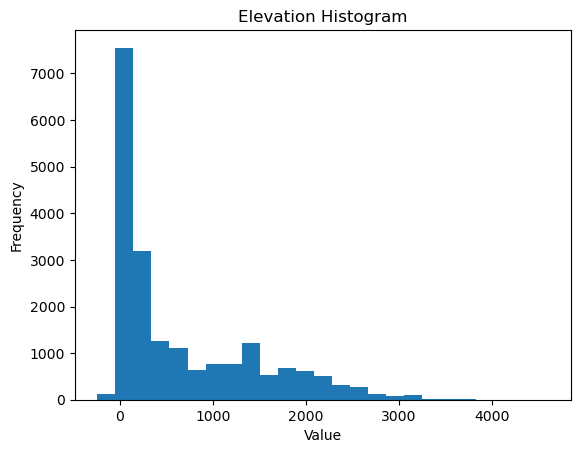

In [1224]:
count = len(df) # Get the total number of rows in the dataframe before removing invalid values
df['elevation'] = df['elevation'].apply(elevation_to_float) # Convert the elevation values to floats
df = df.dropna(subset=['elevation']) # Remove rows with invalid elevation values
count = count - len(df) # Calculate the number of invalid values removed
print_boundry(f'{count} Invalid Elevation Values Removed')
print_range(df['elevation'])
plot_histogram(df['elevation'], 'Elevation Histogram')

There is no theoretical minimum or maximum to elevation, so normalizing values to the range [0,1] presents some issues. The range could be normalized based on the minimums and maximums present in the data but the distribution of data based on the histogram implies a large spread of data at the top of the distrobution. If the outliers at high elevation are too far from the bulk of the values than resolution of information is lost in the bulk of the data. The specifics of the range of outliers was further examined.

In [1225]:
filtered_df = df[(df['elevation'] < df['elevation'].quantile(0.99)) & (df['elevation'] > df['elevation'].quantile(0.01))]
print_boundry(f'Middle 98 percentile of Elevation Values: {len(df) - len(filtered_df)} Elevation Outliers Removed')
print_range(filtered_df['elevation'])

------------- Middle 98 percentile of Elevation Values: 2581 Elevation Outliers Removed -------------
Range Interval: [1.0,2800.0]
Span: 2799.0


By cutting out only the top and bottom 1 percentile of the dataset, the span of the dataset drops from 4840 down to 2799, Implying a large disparity in only a few values. A further analysis was run where the outliers were calulated and filtered out with the following outlier function:

In [1226]:
iqr = df['elevation'].quantile(0.75) - df['elevation'].quantile(0.25) # Calculate the interquartile range
lower_bound = df['elevation'].quantile(0.25) - 1.5 * iqr # Calculate the lower bound
upper_bound = df['elevation'].quantile(0.75) + 1.5 * iqr # Calculate the upper bound
print(f'Lower Bound: {lower_bound:.2f}')
print(f'Upper Bound: {upper_bound:.2f}')

remove_elevation_outliers = lambda x: x if lower_bound <= x <= upper_bound else None # Remove elevation outliers

Lower Bound: -1700.00
Upper Bound: 2940.00


In [1227]:
filtered_df = df['elevation'].apply(remove_elevation_outliers).dropna() # Remove elevation outliers
print_boundry(f'{len(df) - len(filtered_df)} Elevation Outliers Removed')
print_range(filtered_df)

----------------------------------- 191 Elevation Outliers Removed -----------------------------------
Range Interval: [-240.0,2900.0]
Span: 3140.0


The decition was made to normalize the elevation values where instead of mapping the minimum value to 0 and the maximum value to 1 and scaling everything else to match, the values were mapped based on the edges of the outlier range. If the true minimum or maximum was not considered an outlier it was used as the reference point, and if it was considered an outlier, the boundry of the outlier range was used to map the values.

In [1228]:
def normalize_elevation(elevation: float, min=np.maximum(lower_bound, df['elevation'].min()), max=np.minimum(upper_bound, df['elevation'].max())) -> float:
    """Map the elevation value to a range such that the minimum value is 0 and the maximum value is 1 where 
    the minimum value is either the lower bound of outliers or the minimum value in the dataframe, and
    the maximum value is either the upper bound of outliers or the maximum value in the dataframe.

    Args:
        elevation (float): The elevation value to normalize.
        min (float, optional): The minimum value of the range.
        max (float, optional): The maximum value of the range.
    """
    return (elevation - min) / (max - min) # Normalize the elevation to the range [0,1]

In [1229]:
df['elevation'] = df['elevation'].apply(normalize_elevation) # Normalize the elevation values in the dataframe
print_range(df['elevation'], 'Normalized Elevation')
print()
print(f'Total values: {len(df)}')
print(f'Number of elevation values above 1: {len(df[df["elevation"] > 1])}')

Normalized Elevation Range Interval: [0.0,1.5220125786163523]
Normalized Elevation Span: 1.5220125786163523

Total values: 19929
Number of elevation values above 1: 191


Based on this distribution, over 99% of the data is in the range [0,1].

### 3. Final Columns

In [1230]:
print(df.columns)

Index(['rating', 'ebird_code', 'channels', 'date', 'duration', 'filename',
       'latitude', 'sampling_rate', 'type', 'elevation', 'file_type',
       'longitude', 'time', 'common_name', 'sci_name', 'order', 'family',
       'species_group', 'array_size'],
      dtype='object')


#### a) Explanation for Feature Columns

##### (i) `date`

Date Range Interval: [0.0,0.989041095890411]
Date Span: 0.989041095890411


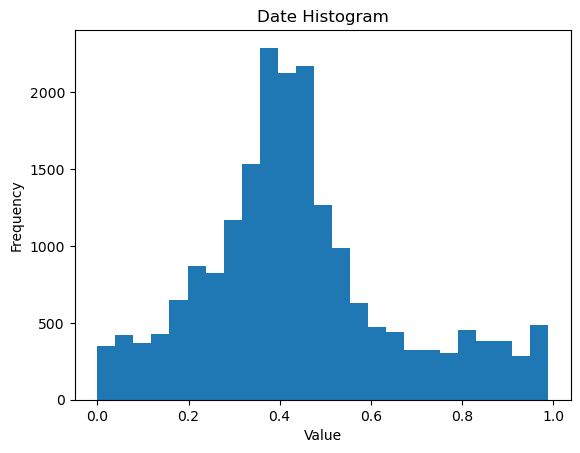

In [1231]:
print_range(df['date'], 'Date')
plot_histogram(df['date'], 'Date Histogram')

##### (ii) `time`

Time Range Interval: [0.0,0.9965277777777778]
Time Span: 0.9965277777777778


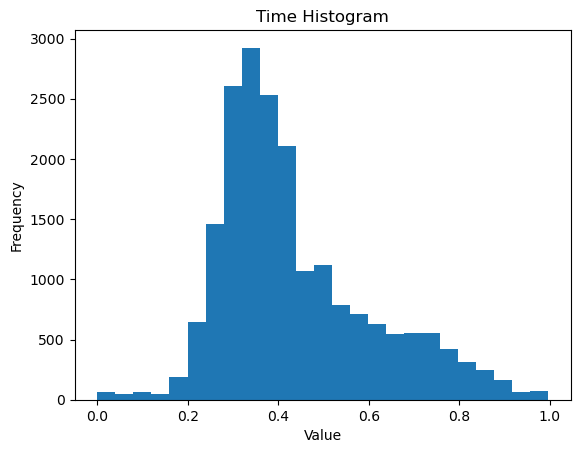

In [1232]:
print_range(df['time'], 'Time')
plot_histogram(df['time'], 'Time Histogram')

##### (iii) `latitude`

Latitude Range Interval: [0.20465555555555556,0.9384894444444445]
Latitude Span: 0.7338338888888889


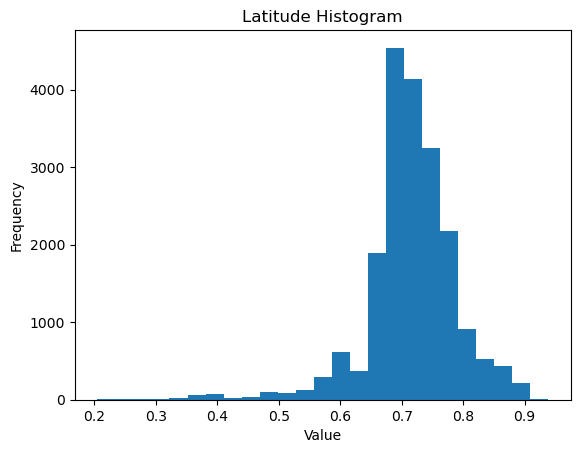

In [1233]:
print_range(df['latitude'], 'Latitude')
plot_histogram(df['latitude'], 'Latitude Histogram')

##### (iv) `longitude`

Longitude Range Interval: [0.022925555555555536,0.9971727777777779]
Longitude Span: 0.9742472222222224


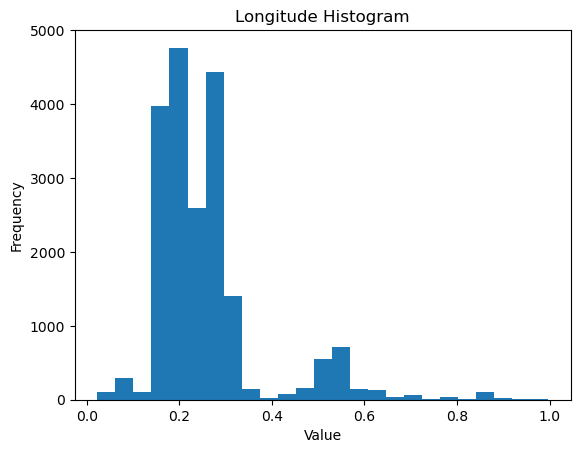

In [1234]:
print_range(df['longitude'], 'Longitude')
plot_histogram(df['longitude'], 'Longitude Histogram')

##### (v) `elevation`

Elevation Range Interval: [0.0,1.5220125786163523]
Elevation Span: 1.5220125786163523


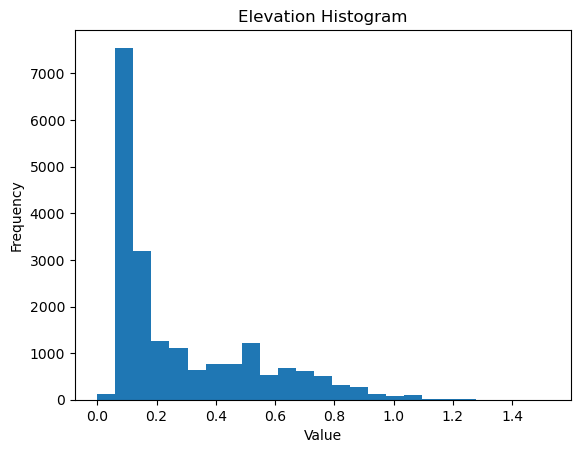

In [1235]:
print_range(df['elevation'], 'Elevation')
plot_histogram(df['elevation'], 'Elevation Histogram')

##### (vi) Audio Signal Features

#### b) Explaination for Target Columns

In [1236]:
print('common_name:', df['common_name'].nunique())
print('sci_name:', df['sci_name'].nunique())
print('order:', df['order'].nunique())
print('family:', df['family'].nunique())
print('species_group:', df['species_group'].nunique())

common_name: 264
sci_name: 264
order: 17
family: 50
species_group: 45


#### c) Explination for Remaining Columns

# § III. Audio Processing Techniques

## A. Audio Metering and Signal Analysis

### 1. Understanding Different Scales
Before delving into advanced audio analysis techniques, it is essential to establish a baseline understanding of some of the concepts explored or nessicary to understand the audio signal effectively. Most properties of sound are percieved non-linearly and here we explore some scales that help us understand aspects of an audio signal.

#### a) Decibel (dB)
The **[decibel](https://en.wikipedia.org/wiki/Decibel)** (symbol: dB) is a relative unit of measurement equal to $\frac{1}{10}$ of a **bel** (B). The **bel** (B) is $\frac{ln(10)}{2}$ **nepers** (not to be confused with a **nat** or a **nepit** which is equal to $\frac{1}{ln(2)}$ **shannons** or, equivalently $\frac{1}{ln(10)}$ **hartleys**). Put together this means: 

$1 dB = \frac{ln(10)}{20} Np$

A neper is named after a John Napier (which notably, is not "John Neper"), One of many mathematicians, statitions, or audio engineers that have things named after them that have funny names, such as Nicholas R. Lomb, and Jeffrey D. Scargle (The minds behind the "Lomb-Scargle Pediogram"). Its important to look at decibels in terms of 'nepers' because it keeps the mood up during this incredibly dry content.

For our calculations, however, we will be looking at comparing the decibel in referenced to a normalized signal magnitude. The decibel is the most common scale to use in audio signal metering and it is applied to many different use cases with slightly different meaning. The decibel itself its simply just a scale but it is applied more specificly depending on the context it is used (ie. dBFS, dBSPL, dBV, dBu all specifically refer to different use cases of the decibel scale all measuring different things). In our case we are applying the decibel scale to our instantaneous signal amplitudes, and the magnitudes of our hilbert envelopes or the frequency magnitudes when converting our time domain signal into a frequency domain signal.

To produce results in reference to the full scale of possible signal magnitude, the signal must be normalized to be in the range [-1,1]. When converting our signal to an array of sample from an audio file it produces values in a range where the maximum and minimum amplitudes corrispond to the largest numbers that could be stored with the datatype used to store each sample, this is refered to as the bit depth of the signal. Traditionally the signal would be normalized such that the minimum and maximum values that could be stored by the datatype are mapped to [-1,1] and the signal is scaled accordingly, but in this case a conscious decision was made to normalize signal values such that the maximum absolute amplitude observed in the signal is what is used to normalize the signal strength. That means that every audio file will have at least one sample at either -1 or 1. This is a simple way to ensure that all of the audio files are percieved by the machine learning model at roughly the same volume.

In [1237]:
def normalize_signal(signal: ndarray, max_amplitude: Optional[number]=None) -> ndarray:
    """Normalizes the amplitude of an audio signal to the range [-1,1].
    Can perform normalization on either the CPU or GPU, depending on the input signal type.
    
    Args:
        signal (cp.ndarray | np.ndarray): The audio signal to normalize.
        max_amplitude (int | float, optional): The maximum amplitude value in the signal. Defaults to None.
    
    Returns:
        cp.ndarray|np.ndarray: The normalized audio signal. Matches the input signal type.
    """
    math = np # Use numpy for CPU operations by default
    if isinstance(signal, cp.ndarray):
        math = cp # Use cupy for GPU operations if the signal is a cupy array
    if max_amplitude is None: # If the maximum amplitude is not provided find the maximum amplitude in the signal
        max_amplitude = math.max(math.abs(signal))
    return signal / max_amplitude # Normalize the signal to the range [-1,1]

To perform the conversion from signal amplitude into decibels, the following formula was used:

$\Large
dB = 20 \cdot \log_{10}(|x[t]+\epsilon|)$

Where $x[t]$ refers to the instantaneous amplitude of the signal at any given time domain. This formula looks and functions the same if the input signal in the time domain is replace with a signal in the frequency domain denoted with the syntax $X[k]$

This deviates from the traditional formula slightly by adding the the constant $\epsilon$ (the number as close to 0 as possible without being 0) to the signal before performing the calculation. This is a simple means of preventing `log(0)` from causing errors. The value for $\epsilon$ is stored in `sys.float_info.epsilon` and by default references that value to perform the calculation.

In [1238]:
def magnitude_to_db(signal: ndarray|number, epsilon: float=sys.float_info.epsilon) -> ndarray|number:
    """Calculate the magnitude of an audio signal in decibels.
    Can perform the calculation on either the CPU or GPU, depending on the input signal type.
    
    Args:
        signal (cp.ndarray | np.ndarray | float | int): The audio signal to calculate the magnitude of. Will take either an array or a single value.
        epsilon (float, optional): A small value to prevent `log(0)`. Defaults to `sys.float_info.epsilon`.
        
    Returns:
        cp.ndarray|np.ndarray|float|int: The magnitude of the audio signal in decibels. Return type matches the input signal type.
    """
    math = np # Use numpy for CPU operations by default
    if isinstance(signal, cp.ndarray):
        math = cp # Use cupy for GPU operations if the signal is a cupy array
    return 20 * math.log10(math.abs(signal + epsilon)) # Calculate the magnitude in decibels

#### b) Frequency Scaling
The signal will be analized from 20 Hz to 20 kHz in this notebook, but how those frequencies are understood by humans (and presumably by birds) is also non-linear. For example: one octaive in music corrisponds to a doubling in frequency. There are many methods used to scale these values to match how they are percieved by people.

##### (i) Log Scale
Logorithmic scaling is the simplest way to analize the frequency domain of the signal, and does corrispond with octiave scaling. This scale is common enough and simple enough that it can be rendered directly inside of `matplotlib`.

##### (ii) Mel Scale
The [Mel Scale](https://en.wikipedia.org/wiki/Mel_scale) (named after the word *melody*) is one of many scales attempting to map more accurately the frequency domain to useful changes in human perception. The mel scale was mapped to measurements of [just-noticeable differences](https://en.wikipedia.org/wiki/Just-noticeable_difference) of pitch by the human ear. This distribution of frequency data is used by many different audio recognition models.

There are many variations of the formula to calulate the Mel Frequency, in this notebook the following formula (from [Douglas O'Shaughnessy, 1987](https://books.google.com/books?id=mHFQAAAAMAAJ&q=2595)) is used to convert $f$ hertz into $m$ mels:

$\Large
Mel(f) = 2595 \log_{10}(1 + \frac{f}{700})
$

In [1239]:
def hz_to_mel(hz: ndarray|number) -> ndarray|number:
    """Convert a frequency value in Hertz to the Mel scale.
    Can perform the conversion on either the CPU or GPU, depending on the input signal type.

    Args:
        hz (cp.ndarray | np.ndarray | float | int): The frequency value in Hertz to convert. Will take either an array or a single value.
    
    Returns:
        cp.ndarray|np.ndarray|float|int: The frequency value converted to the Mel scale. Return type matches the input signal type.
    
    Formula:
    --------
        mel = 2595 * log10(1 + hz / 700)
    """
    if isinstance(hz, cp.ndarray):
        return 2595 * cp.log10(1 + hz / 700)
    return 2595 * np.log10(1 + hz / 700)


def mel_to_hz(mel: ndarray|number) -> ndarray|number:
    """Convert a frequency value in the Mel scale to Hertz.
    Can perform the conversion on either the CPU or GPU, depending on the input signal type.

    Args:
        mel (cp.ndarray | np.ndarray | float | int): The frequency value in the Mel scale to convert. Will take either an array or a single value.
    
    Returns:
        cp.ndarray|np.ndarray|float|int: The frequency value converted to Hertz. Return type matches the input signal type.
    
    Formula:
    --------
        hz = 700 * (10 ** (mel / 2595) - 1)
    """
    return 700 * (10 ** (mel / 2595) - 1)

##### (iii) Bark Scale
The [Bark Scale](https://en.wikipedia.org/wiki/Bark_scale) is another psychoacoustical scale with the goal of providing "a frequency scale on which equal distances correspond with perceptually equal distnaces." It is related to, but less popular than the mel scale, however it is the only scale that has the property of emphasizing the relevance of a "middle range" of frequencies and applying less value to higher frequencies as well as lower frequencies. The original formula to convert to the bark scale is:

$\Large
Bark(f) = 13 tan^{-1}(\frac{0.76f}{1000}) + 3.5 tan^{-1}((\frac{f}{7500})^2)
$

This formula has a more pronounced emphases on middle frequencies with less emphasis on very high frequency values, however it is considerably more difficult to inverse. The inverse function rarely needs to be run and it does not need to run on large amounts of data, so this limitaion was allowed remain. The solution to finding the inverse function is using the `scipy.optimize.root_scalar` to brute force the answers.

In [1240]:
def hz_to_bark(hz: ndarray|number) -> ndarray|number:
    """Convert a frequency value in Hertz to the Bark scale.
    Can perform the conversion on either the CPU or GPU, depending on the input signal type.

    Args:
        hz (cp.ndarray | np.ndarray | float | int): The frequency value in Hertz to convert. Will take either an array or a single value.
    
    Returns:
        cp.ndarray|np.ndarray|float|int: The frequency value converted to the Bark scale. Return type matches the input signal type.
    
    Formula:
    --------
        bark = 13 * arctan(0.00076 * hz) + 3.5 * arctan((hz / 7500) ** 2)
    """
    if isinstance(hz, cp.ndarray):
        return 13 * cp.arctan(0.00076 * hz) + 3.5 * cp.arctan((hz / 7500) ** 2)
    return 13 * np.arctan(0.00076 * hz) + 3.5 * np.arctan((hz / 7500) ** 2)


def bark_to_hz(bark: ndarray|number) -> ndarray|number:
    """Convert a frequency value in the Bark scale to Hertz.
    Slow and inefficient.

    Args:
        bark (cp.ndarray | np.ndarray | float | int): The frequency value in the Bark scale to convert. Will take either an array or a single value.

    Returns:
        cp.ndarray|np.ndarray|float|int: The frequency value converted to Hertz. Return type matches the input signal type.
    """
    def single_bark_to_hz(single_bark):
        return sp.optimize.root_scalar(lambda x: hz_to_bark(x) - single_bark, bracket=[0, 20000], method='brentq').root
    
    if isinstance(bark, cp.ndarray):
        bark = bark.get()
    
    vectorized_bark_to_hz = np.vectorize(single_bark_to_hz)
    return vectorized_bark_to_hz(bark)

##### (iv) Equivalent Rectangular Bandwidth Scale (ERBS)
The Equivelant Rectangular Bandwidth Scale is the last scale on this list which measures the number of percieved audio filters below any given frequency. It is another scale which is adjusted to the perception of sound, rather than the phsycical properties of sound. The following formula was used to calulate the ERBS:

$\Large
ERBS(f) = 21.4 log_{10}(1 + \frac{0.437f}{100})
$

In [1241]:
def hz_to_erbs(hz: ndarray|number) -> ndarray|number:
    """Convert a frequency value in Hertz to the ERB scale.
    Can perform the conversion on either the CPU or GPU, depending on the input signal type.

    Args:
        hz (cp.ndarray | np.ndarray | float | int): The frequency value in Hertz to convert. Will take either an array or a single value.

    Returns:
        cp.ndarray|np.ndarray|float|int: The frequency value converted to the ERB scale. Return type matches the input signal type.

    Formula:
    --------
        erb = 21.4 * log10(1 + hz * 0.00437)
    """
    if isinstance(hz, cp.ndarray):
        return 21.4 * cp.log10(1 + hz * 0.00437)
    return 21.4 * np.log10(1 + hz * 0.00437)


def erbs_to_hz(erbs: ndarray|number) -> ndarray|number:
    """Convert a frequency value in the ERB scale to Hertz.
    Can perform the conversion on either the CPU or GPU, depending on the input signal type.

    Args:
        erbs (cp.ndarray | np.ndarray | float | int): The frequency value in the ERB scale to convert. Will take either an array or a single value.

    Returns:
        cp.ndarray|np.ndarray|float|int: The frequency value converted to Hertz. Return type matches the input signal type.

    Formula:
    --------
        hz = (10 ** (erb / 21.4) - 1) / 0.00437
    """
    return (10 ** (erbs / 21.4) - 1) / 0.00437

##### (v) Visualizing Different Scales
To compare each of these scales, they will all be compared to the logorithmic scale.

In [1242]:
def plot_scale_comparisons(scale_functions: List[Callable[[ndarray|number], ndarray|number]], bins: int=50) -> None:
    """Plot the comparison of multiple frequency scale conversion functions to a logarithmic scale.
    Groups each frequency value into a bin and plots the frequency value against the bin number for each function.
    
    Args:
        scale_functions (List[Callable[[ndarray|number], ndarray|number]]): The frequency scale conversion functions to compare.
        bins (int, optional): The number of bins to group the frequency values into. Defaults to 100.
    """
    frequncies = np.linspace(20, 20000, 19980) # Generate a range of frequencies from 20 Hz to 20 kHz

    fig, ax = plt.subplots(1, len(scale_functions), figsize=(20, 5)) # Set the figure size

    for i, scale_function in enumerate(scale_functions):
        scale_values = scale_function(frequncies) # Convert the frequencies to the scale values
        bin_edges = np.linspace(scale_function(20), scale_function(20000), bins) # Generate the bin values
        bin_numbers = np.digitize(scale_values, bin_edges) # Group the scale values into bins

        ax[i].plot(bin_numbers, frequncies) # Plot the frequency values against the bin numbers
        ax[i].set_title(f'{scale_function.__name__} Scale Comparison')
        ax[i].set_ylabel('Frequency (Hz)')
        ax[i].set_yscale('log')
        yticks = np.array([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000])
        ax[i].set_yticks(yticks, yticks.astype(str))
        ax[i].set_xlabel('Bin Number')
        xticks = np.linspace(1, bin_edges.size, 10).astype(int)
        ax[i].set_xticks(xticks)
        ax[i].grid(True)
    plt.show()

Here we can see how these bins get grouped together at various resolutions. At lower resolutions the plot is easier to understand, and at higher resolutions the curve hidden in each scale becomes more clear.

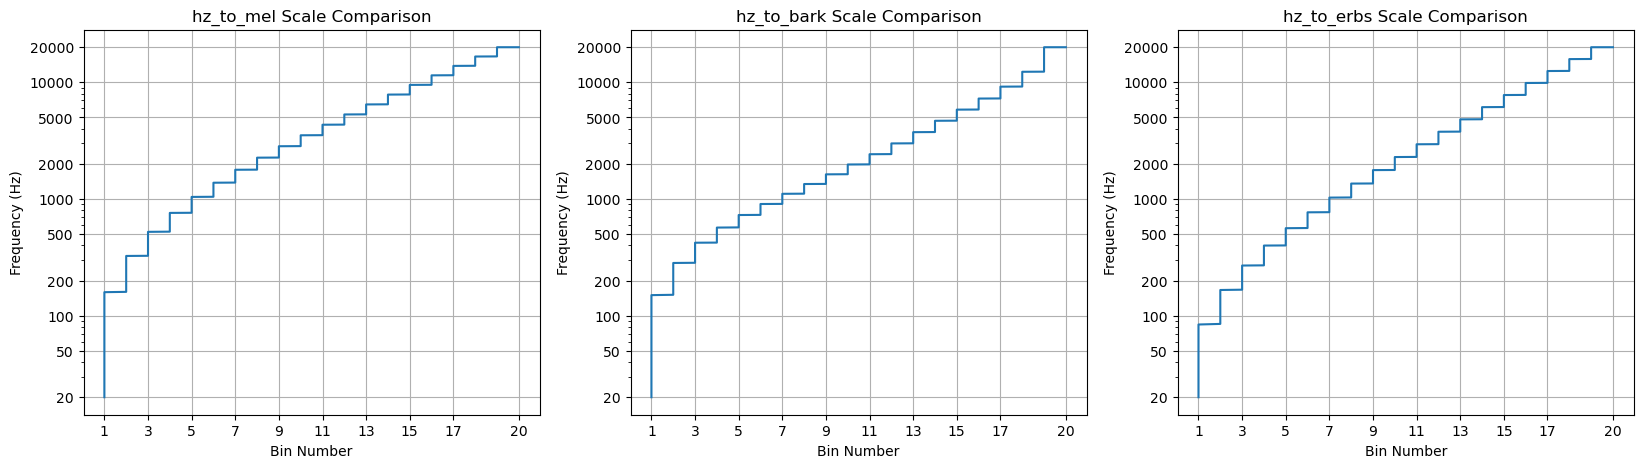

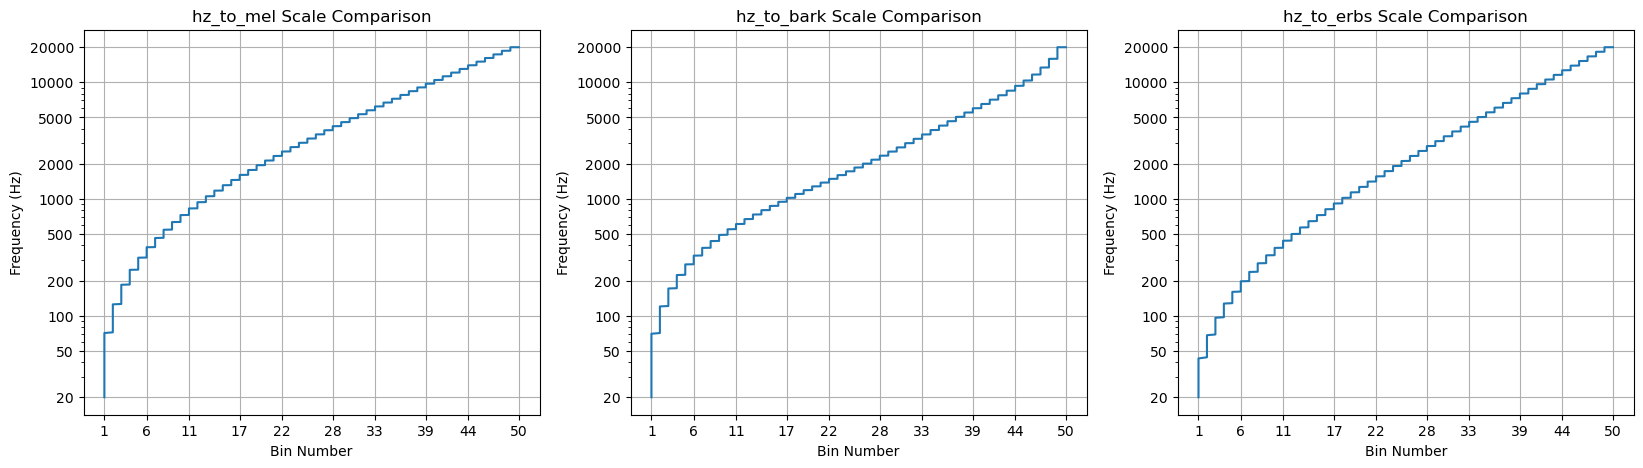

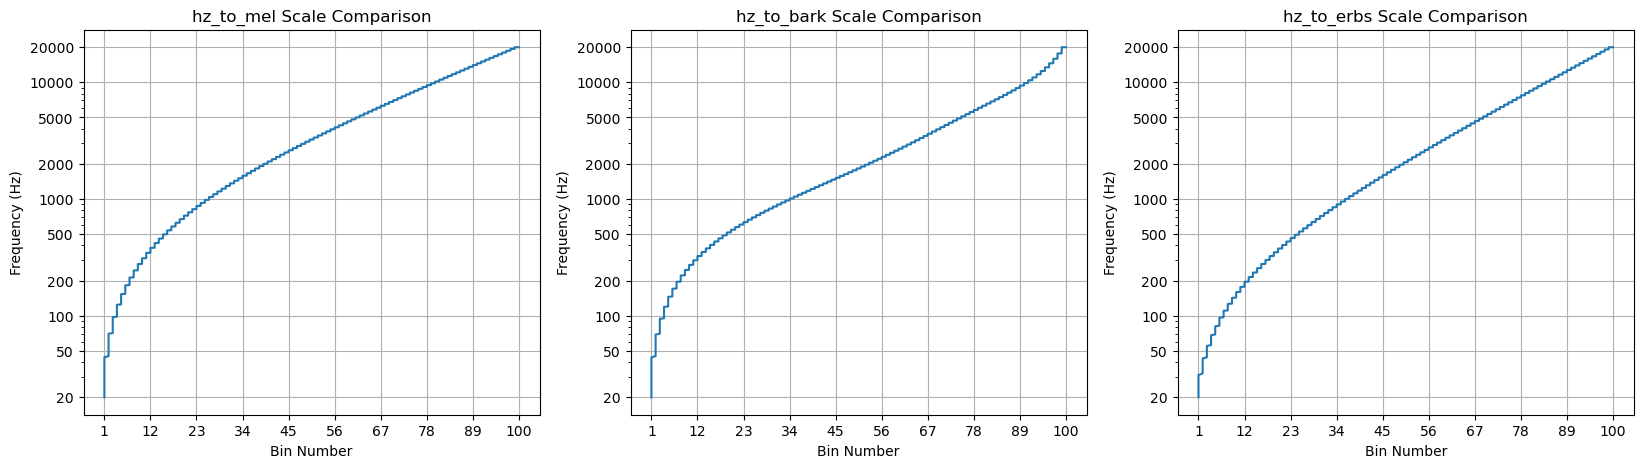

In [1243]:
plot_scale_comparisons([hz_to_mel, hz_to_bark, hz_to_erbs], bins=20)
plot_scale_comparisons([hz_to_mel, hz_to_bark, hz_to_erbs], bins=50)
plot_scale_comparisons([hz_to_mel, hz_to_bark, hz_to_erbs], bins=100)

Here we can see on this chart how the frequencies would get grouped together in different scales. A longer vertical line in each bin means that using that scale, more frequencies would be grouped in that bin. The key things to pay attention to are the scales at the edge of this range, where there is the least amount of useful sonic information coming from birdcalls. The majority of bird information is expected to come from the 100 Hz - 10 kHz range, and especially in the 500 Hz - 5 kHz range. It is for this reason that the Bark scale is used to group and display frequencies in this project.

In [1244]:
frequncies = np.linspace(20, 20000, 19980) # Generate a range of frequencies from 20 Hz to 20 kHz

start = time.time() # Mark the start time
mel = hz_to_mel(frequncies) # Convert the frequencies to the Mel scale
print(f'Time taken to convert frequencies to Mel scale: {time.time() - start:.4f} seconds')

start = time.time() # Mark the start time
hz = mel_to_hz(mel) # Convert the Mel scale values back to frequencies
print(f'Time taken to convert Mel scale values to frequencies: {time.time() - start:.4f} seconds')

start = time.time() # Mark the start time
erbs = hz_to_erbs(frequncies) # Convert the frequencies to the ERB scale
print(f'Time taken to convert frequencies to ERB scale: {time.time() - start:.4f} seconds')

start = time.time() # Mark the start time
hz = erbs_to_hz(erbs) # Convert the ERB scale values back to frequencies
print(f'Time taken to convert ERB scale values to frequencies: {time.time() - start:.4f} seconds')

start = time.time() # Mark the start time
bark = hz_to_bark(frequncies) # Convert the frequencies to the Bark scale
print(f'Time taken to convert frequencies to Bark scale: {time.time() - start:.4f} seconds')

start = time.time() # Mark the start time
hz = bark_to_hz(bark) # Convert the Bark scale values back to frequencies
print(f'Time taken to convert Bark scale values to frequencies: {time.time() - start:.4f} seconds')

Time taken to convert frequencies to Mel scale: 0.0012 seconds
Time taken to convert Mel scale values to frequencies: 0.0004 seconds
Time taken to convert frequencies to ERB scale: 0.0003 seconds
Time taken to convert ERB scale values to frequencies: 0.0005 seconds
Time taken to convert frequencies to Bark scale: 0.0005 seconds
Time taken to convert Bark scale values to frequencies: 0.8157 seconds


This does demonstrate however the large drop in performance when performing the inverse bark conversion. Rather than spending too much effort trying to improve that algorithm, this informaiton was kept in mind through the remainder of the project and the number of calls to the `bark_to_hz` function were minimized.

### 2. Plotting Waveforms

With the scale functions in place, waveforms can now be plotted simply and their amplitudes can be displayed in decibels.

In [1245]:
def signal_to_time(signal: ndarray, sampling_rate: int) -> ndarray:
    """Calculate the time values for each sample in an audio signal.
    Can perform the calculation on either the CPU or GPU, depending on the input signal type.

    Args:
        signal (cp.ndarray | np.ndarray): The audio signal to calculate the time values for.
        sampling_rate (int): The sampling rate of the audio signal.
    
    Returns:
        cp.ndarray|np.ndarray: The time values for each sample in the audio signal. Return type matches the input signal type.
    """
    math = np # Use numpy for CPU operations by default
    if isinstance(signal, cp.ndarray):
        math = cp # Use cupy for GPU operations if the signal is a cupy array
    return math.arange(signal.size) / sampling_rate # Calculate the time values for each sample


def plot_waveform(sound: AudioSegment, title: str='Waveform', normalization_constant: int=None) -> None:
    """Plot the waveform of an audio signal.
    
    Args:
        sound (AudioSegment): The audio signal to plot.
        title (str, optional): The title of the plot. Defaults to 'Waveform'.
        normalization_constant (int, optional): The constant to normalize the signal by. Defaults to None.
    """
    if sound.channels > 1: # If the audio signal has multiple channels, convert it to mono
        sound = sound.split_to_mono()[0]

    signal = np.array(sound.get_array_of_samples()) # Get the audio signal as an array
    signal = normalize_signal(signal, normalization_constant) # Normalize the signal to the range [-1,1]
    time = signal_to_time(signal, sound.frame_rate) # Calculate the time values for each sample
    plt.figure(figsize=(20, 4)) # Long figure to show the waveform clearly
    plt.plot(time, signal) # Plot the waveform
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude (dB)')
    plt.axhline(0, color='black', linewidth=0.5) # Add a horizontal black centerline
    yticks = np.linspace(-1, 1, 15) # Add y-ticks
    yticks_labels = [f'{int(magnitude_to_db(y))}' for y in yticks] # Convert the y-ticks to decibels
    yticks_labels[7] = '-∞' # Replace the center y-tick with negative infinity
    plt.ylim(-1, 1)
    plt.yticks(yticks, yticks_labels)
    plt.grid(True, axis='x')
    xticks = np.linspace(0, time[-1], 10) # Add x-ticks
    depth = 2 if time[-1] > 10 else 1 # Set the depth of the time values
    xticks_labels = [time_to_human_readable(x, depth=depth) for x in xticks] # Convert the x-ticks to human readable time
    plt.xlim(0, time[-1])
    plt.xticks(xticks, xticks_labels)
    plt.show()

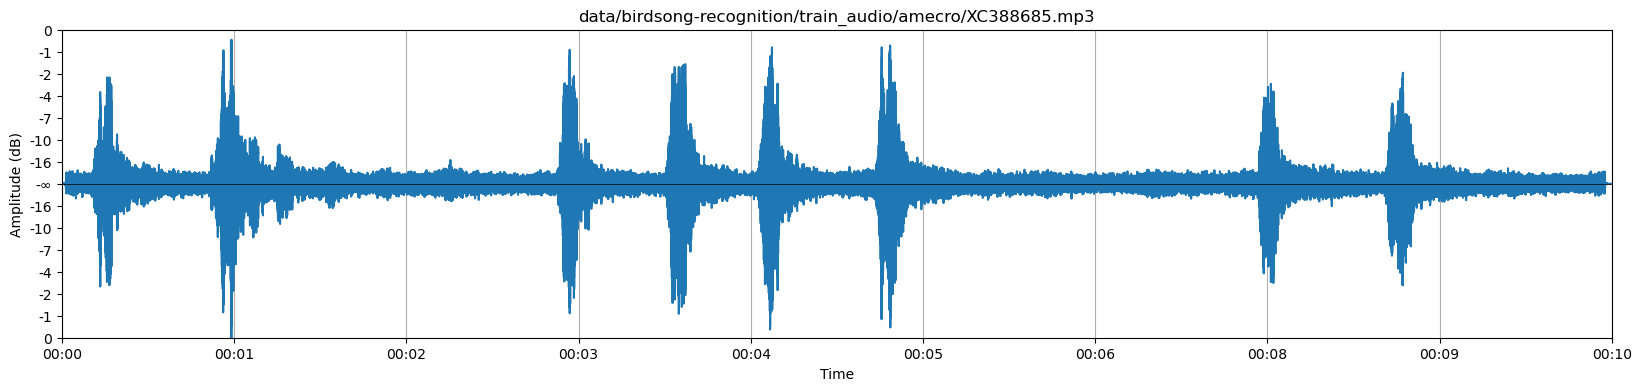

In [1258]:
filename = df.sample(1).filename.iloc[0] # Pick a file, any file.      That was me as a magician. I hope you liked it.
filename = df.filename.iloc[255] # Actually pick this one.
sound = load_sound_file(filename) # Load the audio file
plot_waveform(sound, title=filename) # Show me the magic

#### a) RMS Calculations
In addition to directly plotting the signal, another common technique for analizing signal is to view the signal in terms of short term RMS, where in a window of time (usually about 300 ms) the rms is calulated and that rms number is plotted to give a better picture of how volume is changnig over time without as much instantaneous variance.

In [1259]:
def signal_to_rms_signal(signal: ndarray, sample_rate: int, window_size: int=300, centered: bool=False) -> ndarray:
    """Calculate the Root Mean Square (RMS) of an audio signal. The RMS is calculated over a moving window of the signal.
    Can perform the calculation on either the CPU or GPU, depending on the input signal type.

    Args:
        signal (cp.ndarray | np.ndarray): The audio signal to calculate the RMS of.
        sample_rate (int): The sample rate of the audio signal.
        window_size (int, optional): The size of the moving window in milliseconds. Defaults to 300.
        centered (bool, optional): If True, the RMS is calculated at the center of the window. This is abnormal. Defaults to False.
    
    Returns:
        cp.ndarray|np.ndarray: The RMS of the audio signal. Return type matches the input signal type.
    """
    math = np # Use numpy for CPU operations by default
    if isinstance(signal, cp.ndarray):
        math = cp # Use cupy for GPU operations if the signal is a cupy array
    window_size = int(window_size * sample_rate / 1000) # Convert the window size to samples

    pad_width = window_size // 2 if centered else window_size # Calculate the padding width
    padded_signal = math.pad(signal, pad_width, mode='constant') # Pad the area around the signal making it longer

    cumsum = math.cumsum(padded_signal ** 2) # Calculate the cumulative sum of the squared signal
    cumsum = cumsum[window_size:] - cumsum[:-window_size] # Calculate the difference between the cumulative sums to get the sum of the squared signal in the window
    rms_signal = math.sqrt(cumsum / window_size) # Calculate the RMS of the signal
    
    if centered:
        return rms_signal # Return the RMS signal calculated at the center of the window
    return rms_signal[:-window_size] # Remove the padding from the RMS signal if needed

def plot_rms_signal(sound: AudioSegment, title: str='RMS Signal', normalization_constant: int=None) -> None:
    """Plots the Root Mean Square (RMS) of an audio signal over time.
    
    Args:
        sound (AudioSegment): The audio signal to plot.
        title (str, optional): The title of the plot. Defaults to 'RMS Signal'.
        normalization_constant (int, optional): The constant to normalize the signal by. Defaults to None.
    """
    if sound.channels > 1: # If the audio signal has multiple channels, convert it to mono
        sound = sound.split_to_mono()[0]

    signal = np.array(sound.get_array_of_samples()) # Get the audio signal as an array
    signal = normalize_signal(signal, normalization_constant) # Normalize the signal to the range [-1,1]
    rms_signal = signal_to_rms_signal(signal, sound.frame_rate) # Calculate the RMS of the signal
    time = signal_to_time(rms_signal, sound.frame_rate) # Calculate the time values for each RMS value
    plt.figure(figsize=(20, 4)) # Long figure to show the RMS signal clearly
    plt.plot(time, rms_signal) # Plot the RMS signal
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('RMS Amplitude (dB)')
    plt.grid(True, axis='x')
    xticks = np.linspace(0, time[-1], 10) # Add x-ticks
    depth = 2 if time[-1] > 10 else 1
    xticks_labels = [time_to_human_readable(x, depth=depth) for x in xticks] # Convert the x-ticks to human readable time
    plt.xlim(0, time[-1])
    plt.xticks(xticks, xticks_labels)
    yticks = np.linspace(0, 1, 7) # Add y-ticks. If the number of ticks is too high it will show 0 twice.
    yticks_labels = [f'{int(magnitude_to_db(y))}' for y in yticks]  # Convert the y-ticks to decibels
    yticks_labels[0] = '-∞' # Replace the first y-tick with negative infinity
    plt.ylim(0, 1)
    plt.yticks(yticks, yticks_labels)
    plt.show()

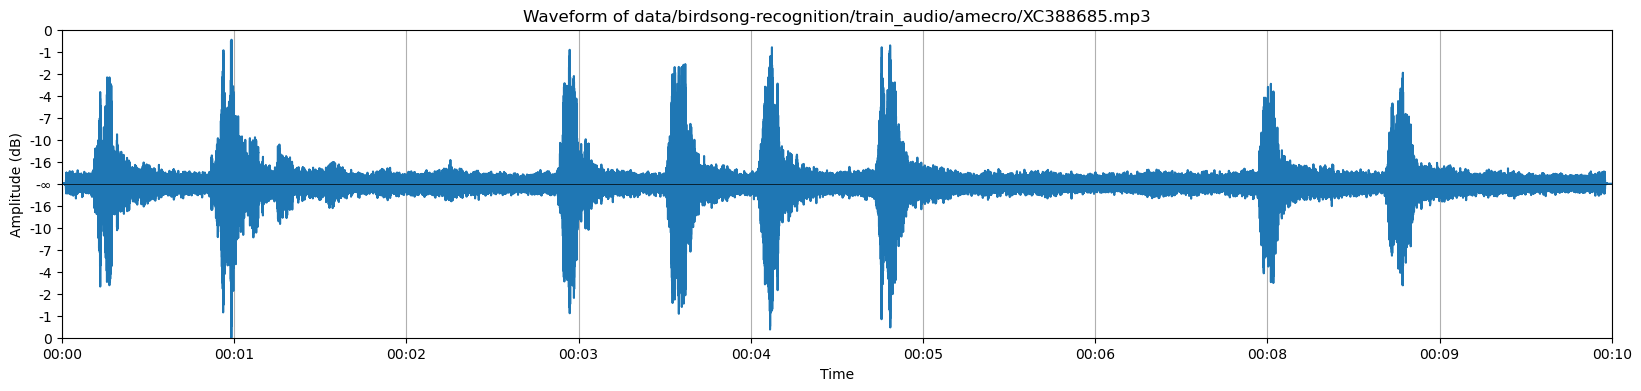

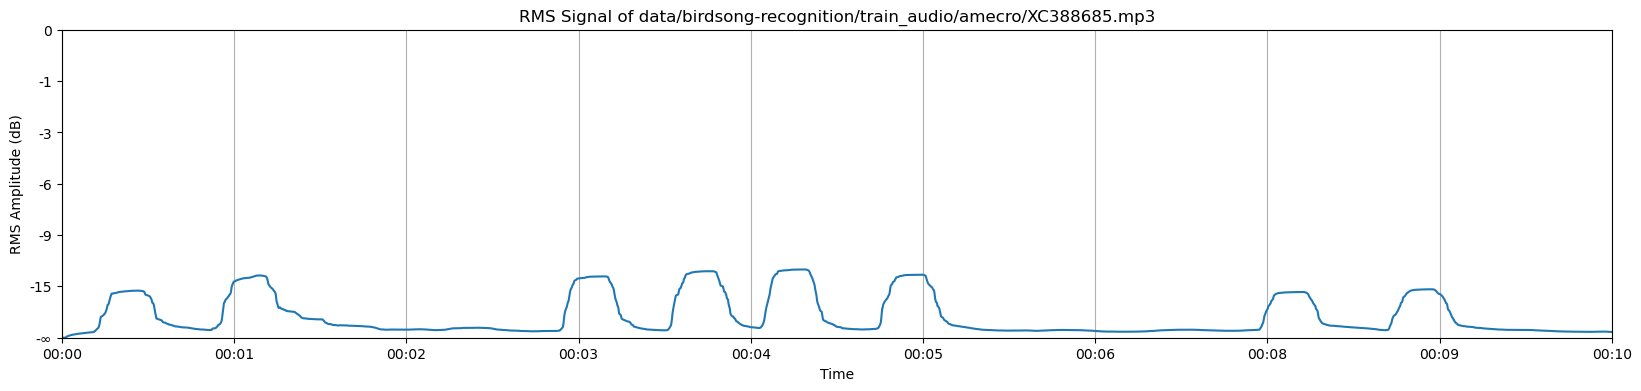

In [1260]:
plot_waveform(sound, title=f'Waveform of {filename}')
plot_rms_signal(sound, title=f'RMS Signal of {filename}')

### 3. Understanding Different Signal Transformations

#### a) The Fourier Transformation

##### (i) Understanding The Complex Result

##### (ii) Advantage of GPU Parallelization when Performing Fourier Transformations

##### (iii) Grouping Frequencies Together

##### (iv) Example Frequency Spectrums

#### b) The Short-Time Fourier Transformation (STFT)

##### (i) Advantage of GPU Parallelization when Performing Short-Time Fourier Transformations

##### (ii) The Inverse Short-Time Fourier Transformation

##### (iii) The Constant OverLap Add (COLA) Constraint

##### (iv) The Nonzero OverLap Add (NOLA) Constraint

##### (v) Grouping Frequencies Together

##### (vi) Example Spectrograms

#### c) The Hilbert Transformation

##### (i) Understanding the Analytic Signal

##### (ii) Advantage of GPU Parallelization when Performing Hilbert Transformations

##### (iii) Extracting the Real Signal

##### (iv) Extracting the Hilbert Envelope

##### (v) Extracting the Instantaneous Phase Angle

##### (vi) Example Plots of Hilbert Envelopes

##### (vii) Example Plots of Signal Phase Angles

## B. Generation of Simple Frequency Representation Dataset

### 1. Performing the Bulk Calculation

### 2. Visualizations of Resulting Data

#### a) Individual Frequency Spectrums

#### b) Heatmaps of Frequency Spectrums

## C. Audio Signal Processing Techniques

### 1. Reduction of the Noise Floor

#### a) Issues Caused by Noise Floor

#### b) Method of Noise Reduction

#### c) Noise Reduction Examples

### 2. Reduction of Momentary Clicks

#### a) Issued Caused by Clicks

#### b) Means of Detecting Clicks

##### (i) Peak Detection

##### (ii) Calcuating the Click-Sensitive Signal

#### c) Reducing Magnitude around Clicks

### 3. Retuction Of Transient Response

#### a) Introduction to Signal Transients

#### b) Issues Caused by Transients

#### c) Calculating the Transient-Sensitive Signal

#### d) Reducing Magnitude around Transients

### 4. Segmentation of Audio into Normalized Windows

## D. Generation of Filtered Frequency Representation Dataset

## E. Generation of Filtered Time-Frequency Representation Dataset

# § IV. Model Training and Evaluation

## A. Simple Frequency Representation Dataset

## B. Filtered Frequency Representation Dataset

# § V. Advanced Model Training and Species Detection

## A. Training a Convolutional Neural Network (CNN) Against the Filtered Time-Frequency Representation Dataset

## B. Model Training with Species as a Target

## C. Training a Convolutional Neural Network (CNN) with Species as a Target

# § VI. Practical Application and Use of Given Test Data

## A. Recreating the Audio Processing Pipeline

## B. Making the Processing Function

## C. Testing Against the Given Test Data